In [2]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.15.0
Pandas Version: 1.5.3
Numpy Version: 1.23.5
System Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [3]:
# Data Loader Parameters
BATCH_SIZE = 256
BUFFER_SIZE = 10000
TRAIN_SPLIT = 300000

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 4
PATIENCE = 5

# Reproducibility
SEED = 13
tf.random.set_seed(SEED)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.listdir('drive/My Drive/')

In [5]:
import pandas as pd
df= pd.read_csv('drive/My Drive/jena_climate_2016-2023.csv', encoding='latin1')
df.shape

(411592, 22)

# **Visualization**

In [6]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m²)',
       'PAR (µmol/m²/s)', 'max. PAR (µmol/m²/s)', 'Tlog (degC)', 'CO2 (ppm)'],
      dtype='object')

In [7]:
df.head(7)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
0,01.01.2016 00:00:00,999.08,-0.01,273.22,-0.44,96.9,6.10,5.91,0.19,3.69,...,1.16,2.04,192.4,0.0,0,0.0,0.0,0.0,11.54,426.9
1,01.01.2016 00:10:00,999.03,0.01,273.25,-0.41,97.0,6.11,5.93,0.18,3.70,...,1.01,2.12,211.6,0.0,0,0.0,0.0,0.0,11.58,427.1
2,01.01.2016 00:20:00,999.07,0.06,273.29,-0.36,97.0,6.13,5.95,0.18,3.71,...,0.80,1.52,203.8,0.0,0,0.0,0.0,0.0,11.60,426.8
3,01.01.2016 00:30:00,999.09,0.07,273.30,-0.36,96.9,6.14,5.95,0.19,3.71,...,0.77,1.64,184.2,0.0,0,0.0,0.0,0.0,11.62,426.9
4,01.01.2016 00:40:00,999.09,-0.05,273.18,-0.50,96.8,6.09,5.89,0.19,3.68,...,0.84,1.92,200.1,0.0,0,0.0,0.0,0.0,11.64,427.7
5,01.01.2016 00:50:00,999.08,0.07,273.30,-0.33,97.1,6.14,5.96,0.18,3.72,...,0.33,0.84,159.8,0.0,0,0.0,0.0,0.0,11.65,428.6
6,01.01.2016 01:00:00,999.06,-0.05,273.18,-0.52,96.6,6.09,5.88,0.21,3.67,...,0.36,0.76,163.5,0.0,0,0.0,0.0,0.0,11.66,429.1


In [8]:
len(df)/144   #  Total study was done for 2858 days

2858.277777777778

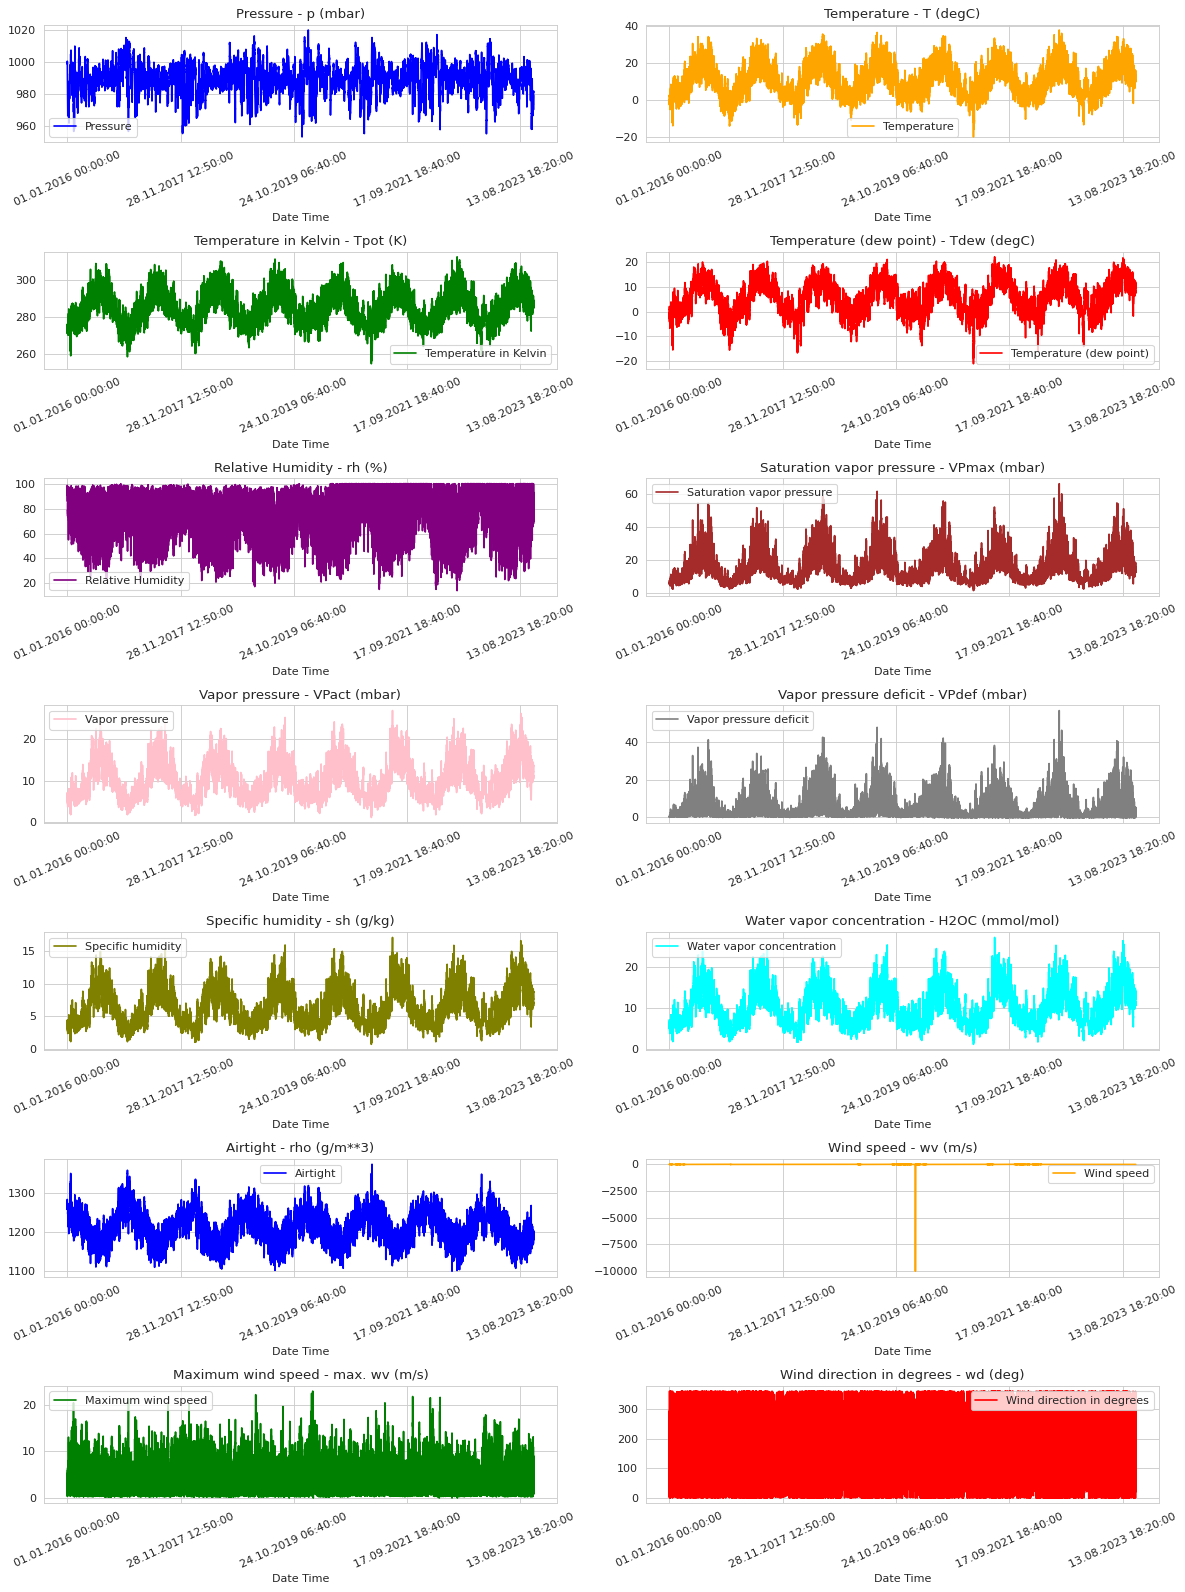

In [ ]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()
    plt.savefig("Data Features.png", format="png", dpi=300)


show_raw_visualization(df)

<ipython-input-9-a20ba9bc3e8f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(data.corr())


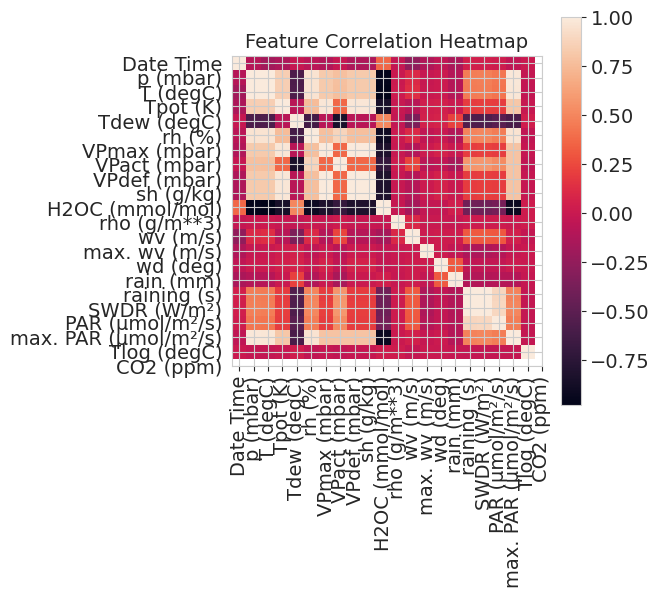

In [9]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.savefig("/content/heatmap.png", format="png", dpi=300)
    plt.show()


show_heatmap(df)

# **Univariate**

you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])

    return np.array(data), np.array(labels)


Let's first extract only the temperature from the dataset.

In [ ]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2016 00:00:00   -0.01
01.01.2016 00:10:00    0.01
01.01.2016 00:20:00    0.06
01.01.2016 00:30:00    0.07
01.01.2016 00:40:00   -0.05
Name: T (degC), dtype: float64

In [ ]:
uni_data = uni_data.values  # converting into numpy array

In [ ]:
uni_data.shape

(411592,)

It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.You could also use a `tf.keras.utils.normalize` method that rescales the values into a range of [0,1].

Note: The mean and standard deviation should only be computed using the training data.

In [ ]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's standardize the data.

In [ ]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. The model will be given the last 3 days recorded temperature observations(432 samples), and needs to learn to predict the temperature after 12 hrs.

In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))

# **Univariate Window size 432 (3 days past data) and prediction after 12 hrs.**

In [ ]:
univariate_past_history = 432
univariate_future_target = 72

x_train_uni, y_train_uni = univariate_data(dataset=uni_data,
                                           start_index=0,
                                           end_index=TRAIN_SPLIT,
                                           history_size=univariate_past_history,
                                           target_size=univariate_future_target)
x_val_uni, y_val_uni = univariate_data(dataset=uni_data,
                                       start_index=TRAIN_SPLIT,
                                       end_index=None,
                                       history_size=univariate_past_history,
                                       target_size=univariate_future_target)

In [ ]:
x_train_uni.shape, y_train_uni.shape, x_val_uni.shape, y_train_uni.shape

((299568, 432, 1), (299568,), (111088, 432, 1), (299568,))

In [ ]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
complicated_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=x_train_uni.shape[-2:]),  # LSTM layer with 64 units
    tf.keras.layers.LSTM(32, return_sequences=True),  # Another LSTM layer with 32 units
    tf.keras.layers.LSTM(16),  # Another LSTM layer with 16 units

    tf.keras.layers.Dense(32, activation='relu'),  # Dense layer with 32 units and ReLU activation
    tf.keras.layers.Dropout(0.2),  # Dropout layer for regularization

    tf.keras.layers.Dense(1)  # Output layer
])

complicated_lstm_model.compile(optimizer='adam', loss='mae')
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
lstm_history = complicated_lstm_model.fit(train_univariate,
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate,
                      callbacks=[early_stopping],
                      validation_steps=50)

Epoch 1/4
200/200 [==============================] - 20s 58ms/step - loss: 0.4096 - val_loss: 0.2816
Epoch 2/4
200/200 [==============================] - 11s 53ms/step - loss: 0.2946 - val_loss: 0.2681
Epoch 3/4
200/200 [==============================] - 12s 58ms/step - loss: 0.3158 - val_loss: 0.2665
Epoch 4/4
200/200 [==============================] - 12s 60ms/step - loss: 0.3039 - val_loss: 0.2582


8/8 [==============================] - 0s 17ms/step


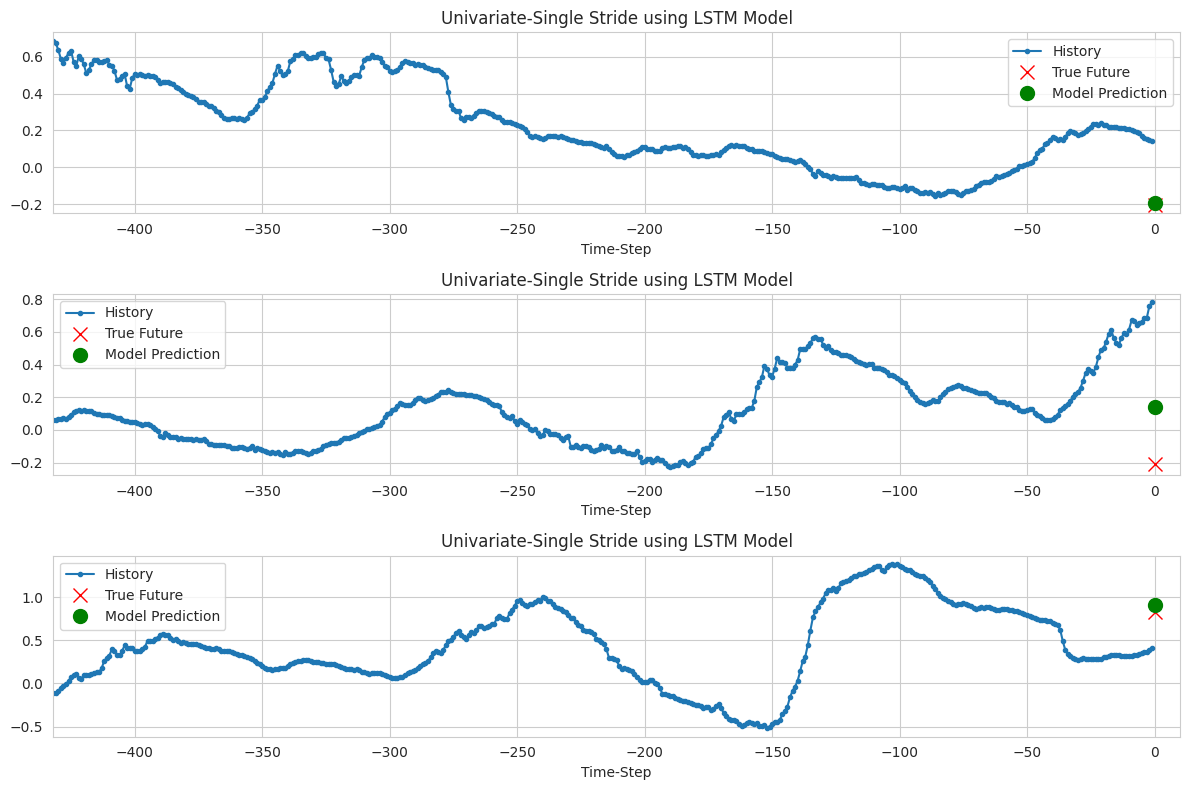

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_plot(plot_data, delta, title, ax):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    ax.set_title(title)
    for i, x in enumerate(plot_data):
        if i:
            ax.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            ax.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        ax.legend()
        ax.set_xlim([time_steps[0], (future + 5) * 2])
        ax.set_xlabel('Time-Step')

# Create a single figure to contain all three subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8))

for i, (x, y) in enumerate(val_univariate.take(3)):
    # Create a subplot for each sample
    ax = axs[i]
    plot_data = [x[0].numpy(), y[0].numpy(), complicated_lstm_model.predict(x)[0]]
    show_plot(plot_data, 0, 'Univariate-Single Stride using LSTM Model', ax)

# Save the entire figure with all three subplots
plt.tight_layout()
plt.savefig("/content/Univariate-Single Stride LSTM model.png", format="png", dpi=300)


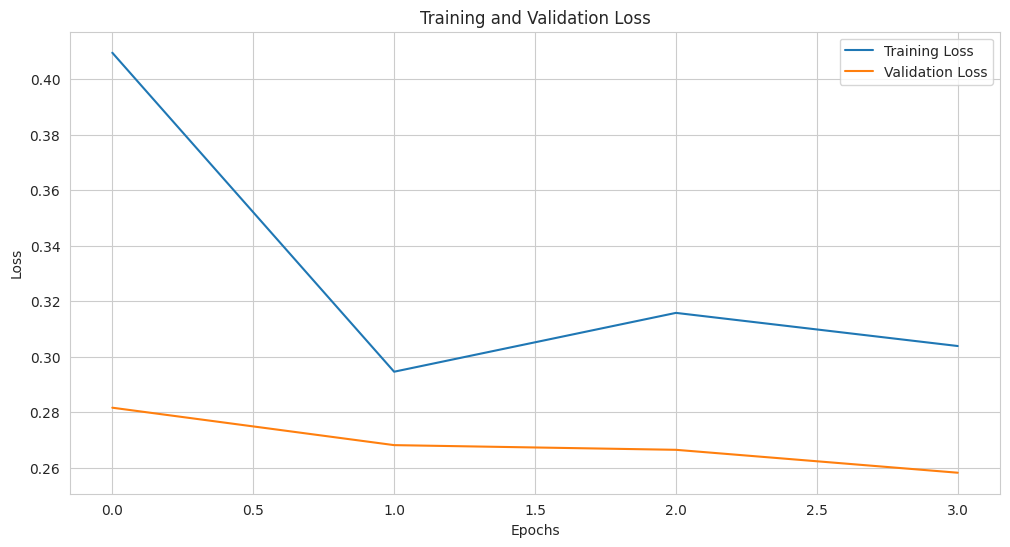

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
#plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/content/uvss_lstm_Loss.png", format="png", dpi=300)

plt.show()

In [ ]:
print('Training Loss: ', lstm_history.history['loss'])
print('Validiation Loss: ', lstm_history.history['val_loss'])

Training Loss:  [0.40960612893104553, 0.2946031093597412, 0.3158145248889923, 0.3038681149482727]
Validiation Loss:  [0.28163251280784607, 0.26813721656799316, 0.26645010709762573, 0.25819024443626404]


In [ ]:
del complicated_lstm_model, lstm_history

In [ ]:
import tensorflow as tf

complicated_rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(64, return_sequences=True, input_shape=x_train_uni.shape[-2:], activation='relu'),  # RNN layer with 64 units and ReLU activation
    tf.keras.layers.SimpleRNN(32, return_sequences=True, activation='relu'),  # Another RNN layer with 32 units and ReLU activation
    tf.keras.layers.SimpleRNN(16, activation='relu'),  # Another RNN layer with 16 units and ReLU activation

    tf.keras.layers.Dense(32, activation='relu'),  # Dense layer with 32 units and ReLU activation
    tf.keras.layers.Dropout(0.2),  # Dropout layer for regularization

    tf.keras.layers.Dense(1)  # Output layer
])

complicated_rnn_model.compile(optimizer='adam', loss='mae')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

rnn_history = complicated_rnn_model.fit(train_univariate,
                               epochs=EPOCHS,
                               steps_per_epoch=EVALUATION_INTERVAL,
                               validation_data=val_univariate,
                               callbacks=[early_stopping],
                               validation_steps=50)

Epoch 1/4
200/200 [==============================] - 249s 1s/step - loss: 0.5042 - val_loss: 0.4004
Epoch 2/4
200/200 [==============================] - 232s 1s/step - loss: 0.4570 - val_loss: 0.3840
Epoch 3/4
200/200 [==============================] - 224s 1s/step - loss: 0.4974 - val_loss: 0.3857
Epoch 4/4
200/200 [==============================] - 228s 1s/step - loss: 0.5074 - val_loss: 0.4028


8/8 [==============================] - 1s 99ms/step


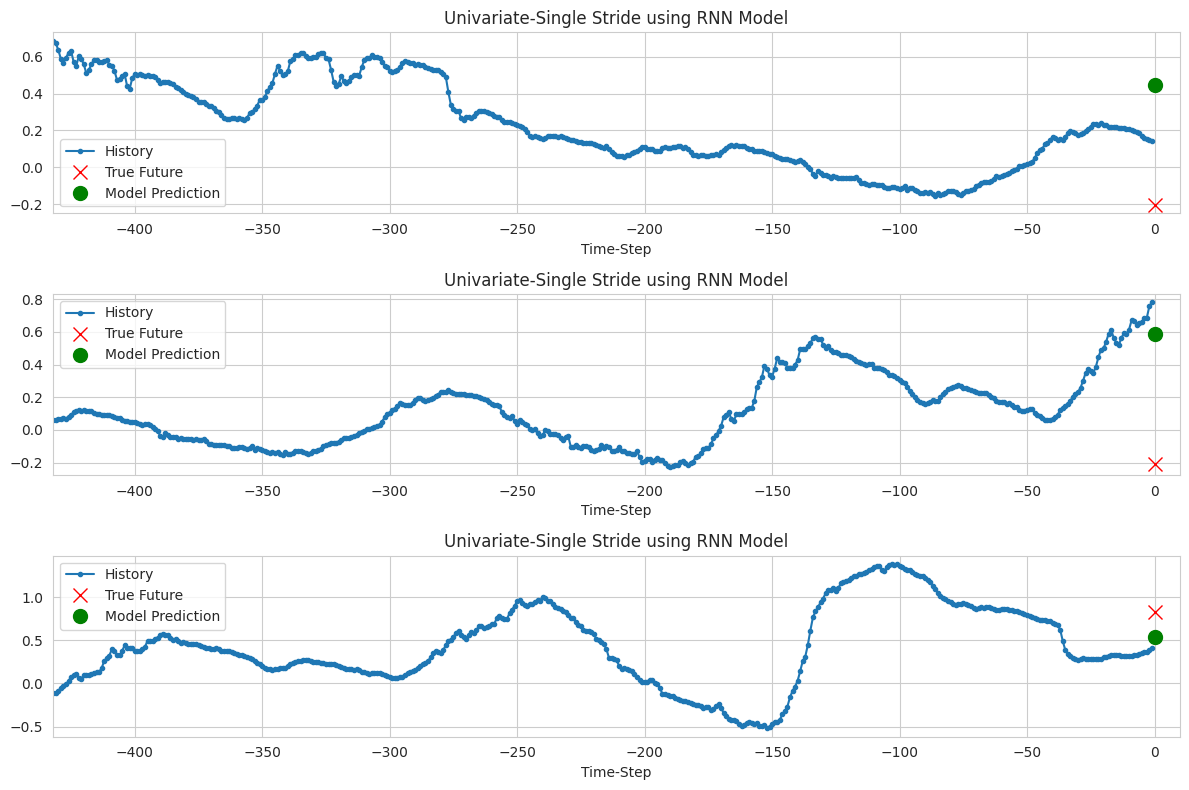

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_plot(plot_data, delta, title, ax):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    ax.set_title(title)
    for i, x in enumerate(plot_data):
        if i:
            ax.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            ax.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        ax.legend()
        ax.set_xlim([time_steps[0], (future + 5) * 2])
        ax.set_xlabel('Time-Step')

# Create a single figure to contain all three subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8))

for i, (x, y) in enumerate(val_univariate.take(3)):
    # Create a subplot for each sample
    ax = axs[i]
    plot_data = [x[0].numpy(), y[0].numpy(), complicated_rnn_model.predict(x)[0]]
    show_plot(plot_data, 0, 'Univariate-Single Stride using RNN Model', ax)

# Save the entire figure with all three subplots
plt.tight_layout()
plt.savefig("/content/RNN_Univariate-Single Stride.png", format="png", dpi=300)

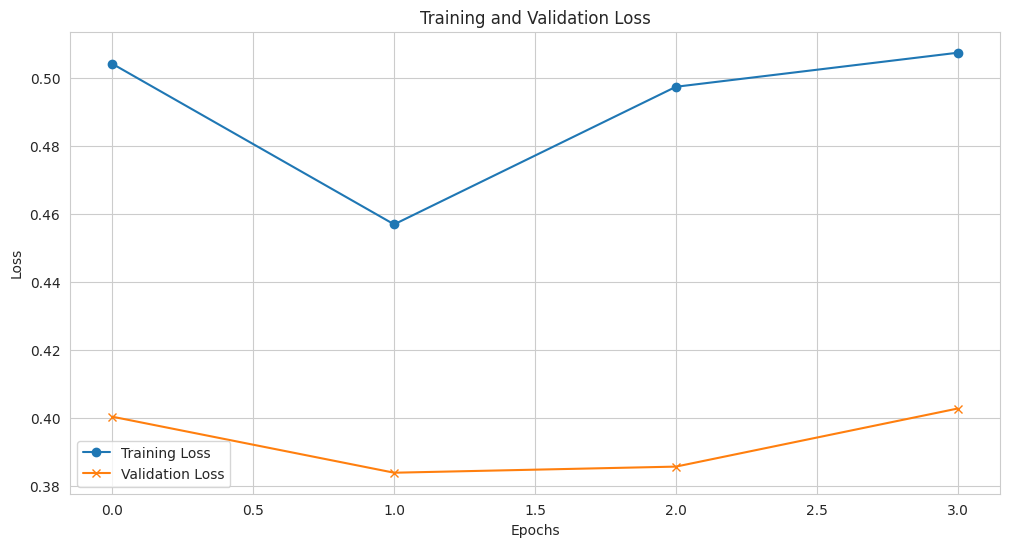

In [ ]:
plt.figure(figsize=(12, 6))
#plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['loss'], label='Training Loss', marker='o')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/content/uvss_RNN_Loss.png", format="png", dpi=300)

plt.show()

In [ ]:
print('Training Loss: ', rnn_history.history['loss'])
print('Validiation Loss: ', rnn_history.history['val_loss'])

Training Loss:  [0.504169225692749, 0.4569622278213501, 0.4974135160446167, 0.5074241161346436]
Validiation Loss:  [0.40042227506637573, 0.38395145535469055, 0.38574835658073425, 0.40282708406448364]


In [ ]:
del complicated_rnn_model, rnn_history

In [ ]:
from tensorflow.keras.layers import GRU

# Define the GRU model
gru_model = tf.keras.models.Sequential([
    GRU(8, input_shape=x_train_uni.shape[-2:], activation='tanh', recurrent_activation='sigmoid'),
    tf.keras.layers.Dense(1)
])

gru_model.compile(optimizer='adam', loss='mae')

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

gru_history = gru_model.fit(train_univariate,
                       epochs=EPOCHS,
                       steps_per_epoch=EVALUATION_INTERVAL,
                       validation_data=val_univariate,
                       callbacks=[early_stopping],
                       validation_steps=50)


Epoch 1/4
200/200 [==============================] - 6s 19ms/step - loss: 0.3176 - val_loss: 0.3171
Epoch 2/4
200/200 [==============================] - 4s 20ms/step - loss: 0.2962 - val_loss: 0.2922
Epoch 3/4
200/200 [==============================] - 4s 19ms/step - loss: 0.3244 - val_loss: 0.3002
Epoch 4/4
200/200 [==============================] - 4s 18ms/step - loss: 0.3164 - val_loss: 0.2848


In [ ]:

complicated_gru_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(64, return_sequences=True, input_shape=x_train_uni.shape[-2:], activation='relu'),  # GRU layer with 64 units and ReLU activation
    tf.keras.layers.GRU(32, return_sequences=True, activation='relu'),  # Another GRU layer with 32 units and ReLU activation
    tf.keras.layers.GRU(16, activation='relu'),  # Another GRU layer with 16 units and ReLU activation

    tf.keras.layers.Dense(32, activation='relu'),  # Dense layer with 32 units and ReLU activation
    tf.keras.layers.Dropout(0.2),  # Dropout layer for regularization

    tf.keras.layers.Dense(1)  # Output layer
])

complicated_gru_model.compile(optimizer='adam', loss='mae')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

gru_history = complicated_gru_model.fit(train_univariate,
                       epochs=EPOCHS,
                       steps_per_epoch=EVALUATION_INTERVAL,
                       validation_data=val_univariate,
                       callbacks=[early_stopping],
                       validation_steps=50)


Epoch 1/4
200/200 [==============================] - 469s 2s/step - loss: 0.5137 - val_loss: 0.3756
Epoch 2/4
200/200 [==============================] - 450s 2s/step - loss: 0.3423 - val_loss: 0.3042
Epoch 3/4
200/200 [==============================] - 442s 2s/step - loss: 0.3438 - val_loss: 0.2904
Epoch 4/4
200/200 [==============================] - 438s 2s/step - loss: 0.3241 - val_loss: 0.2795


8/8 [==============================] - 2s 298ms/step


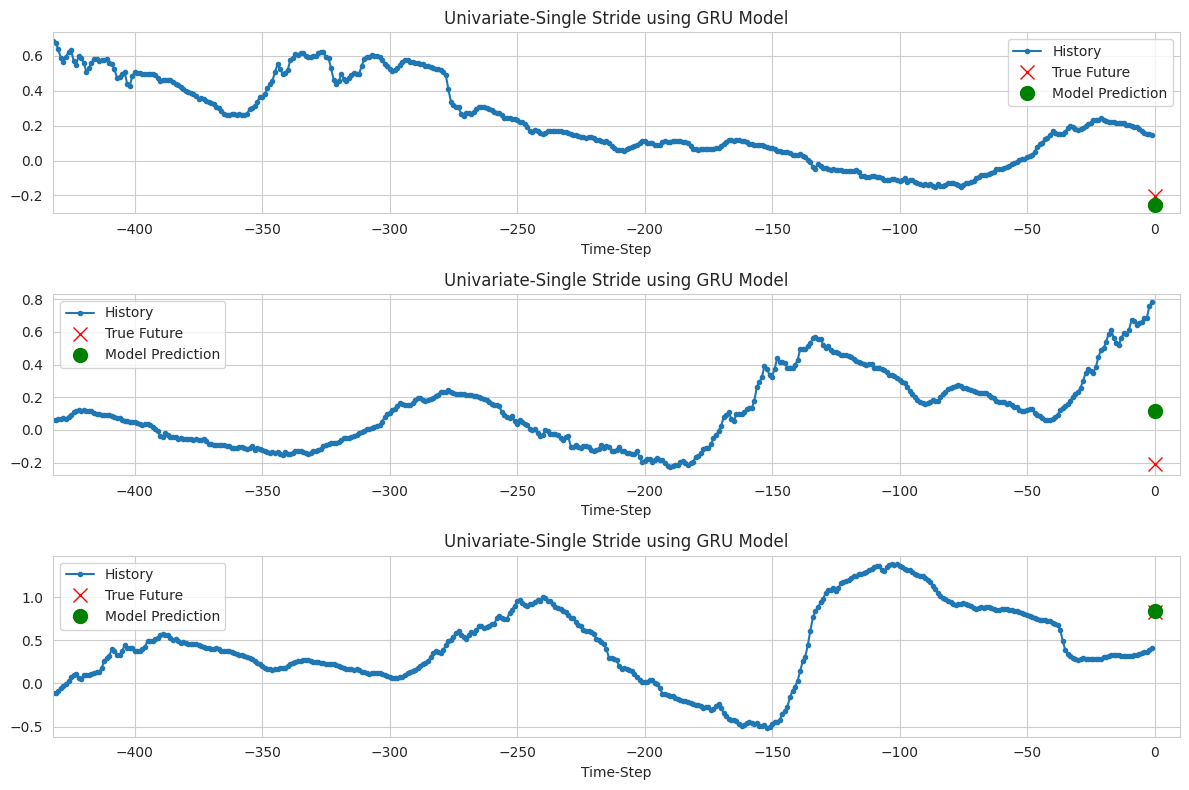

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_plot(plot_data, delta, title, ax):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    ax.set_title(title)
    for i, x in enumerate(plot_data):
        if i:
            ax.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            ax.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        ax.legend()
        ax.set_xlim([time_steps[0], (future + 5) * 2])
        ax.set_xlabel('Time-Step')

# Create a single figure to contain all three subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8))

for i, (x, y) in enumerate(val_univariate.take(3)):
    # Create a subplot for each sample
    ax = axs[i]
    plot_data = [x[0].numpy(), y[0].numpy(), complicated_gru_model.predict(x)[0]]
    show_plot(plot_data, 0, 'Univariate-Single Stride using GRU Model', ax)

# Save the entire figure with all three subplots
plt.tight_layout()
plt.savefig("/content/GRU_Univariate-Single Stride.png", format="png", dpi=300)

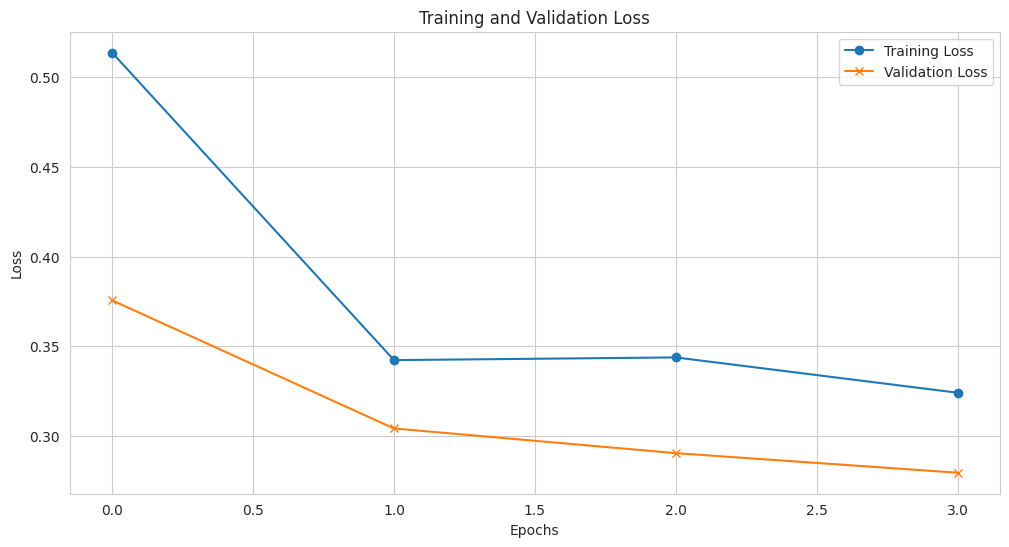

In [ ]:
plt.figure(figsize=(12, 6))
#plt.subplot(1, 2, 1)
plt.plot(gru_history.history['loss'], label='Training Loss', marker='o')
plt.plot(gru_history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/content/uvss_GRU_Loss.png", format="png", dpi=300)

plt.show()

In [ ]:
print('Training Loss: ', gru_history.history['loss'])
print('Validiation Loss: ', gru_history.history['val_loss'])

Training Loss:  [0.5136675238609314, 0.34231114387512207, 0.3438088893890381, 0.32412952184677124]
Validiation Loss:  [0.37562096118927, 0.3042120933532715, 0.2904485762119293, 0.27953803539276123]


In [ ]:
del complicated_gru_model,gru_history

**Transformer Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Model

def create_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = MultiHeadAttention(num_heads=8, key_dim=64)(inputs, inputs)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)

    return model

input_shape = x_train_uni.shape[-2:]
transformer_model = create_transformer_model(input_shape)
transformer_model.compile(optimizer='adam', loss='mae')

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

trans_history = transformer_model.fit(train_univariate,
                       epochs=EPOCHS,
                       steps_per_epoch=EVALUATION_INTERVAL,
                       validation_data=val_univariate,
                       callbacks=[early_stopping],
                       validation_steps=50)


Epoch 1/4
200/200 [==============================] - 56s 270ms/step - loss: 0.4674 - val_loss: 0.3535
Epoch 2/4
200/200 [==============================] - 54s 268ms/step - loss: 0.3887 - val_loss: 0.3537
Epoch 3/4
200/200 [==============================] - 54s 269ms/step - loss: 0.4333 - val_loss: 0.3484
Epoch 4/4
200/200 [==============================] - 54s 272ms/step - loss: 0.4354 - val_loss: 0.3605


8/8 [==============================] - 0s 13ms/step


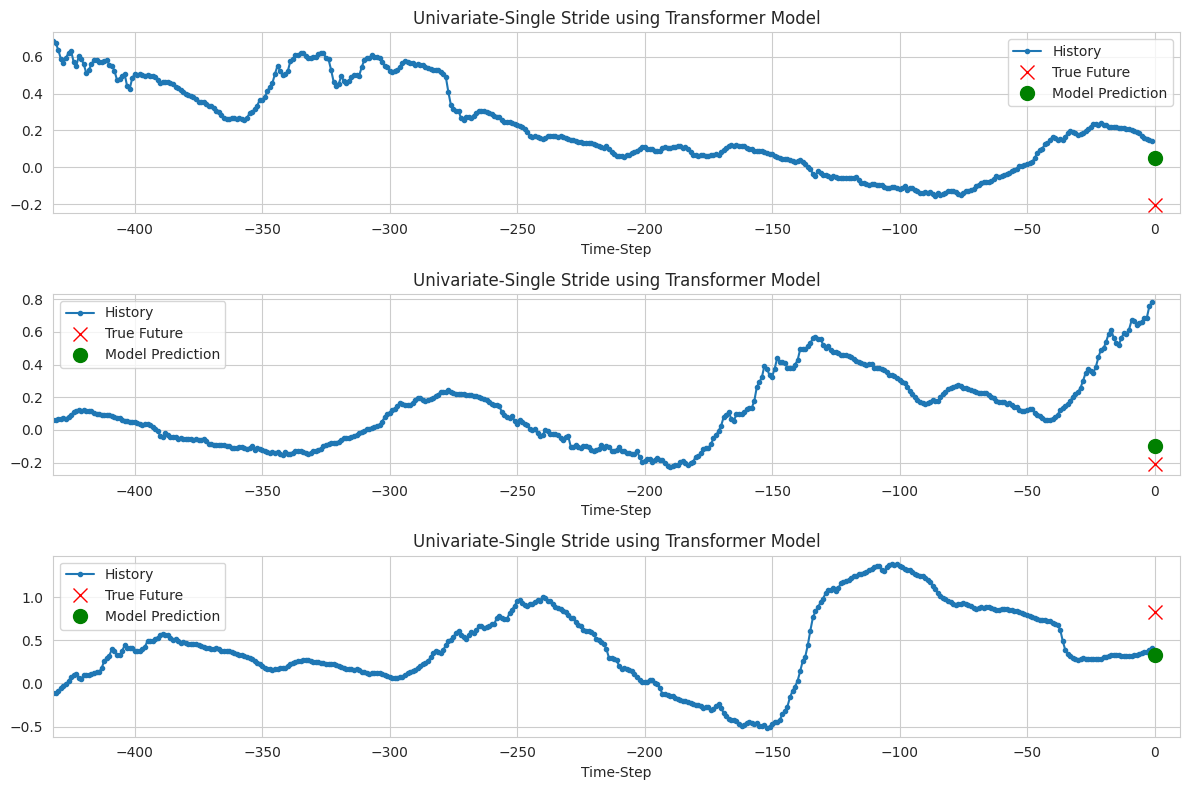

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_plot(plot_data, delta, title, ax):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    ax.set_title(title)
    for i, x in enumerate(plot_data):
        if i:
            ax.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            ax.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        ax.legend()
        ax.set_xlim([time_steps[0], (future + 5) * 2])
        ax.set_xlabel('Time-Step')

# Create a single figure to contain all three subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8))

for i, (x, y) in enumerate(val_univariate.take(3)):
    # Create a subplot for each sample
    ax = axs[i]
    plot_data = [x[0].numpy(), y[0].numpy(), transformer_model.predict(x)[0]]
    show_plot(plot_data, 0, 'Univariate-Single Stride using Transformer Model', ax)

# Save the entire figure with all three subplots
plt.tight_layout()
plt.savefig("/content/Transformer_Univariate-Single Stride.png", format="png", dpi=300)

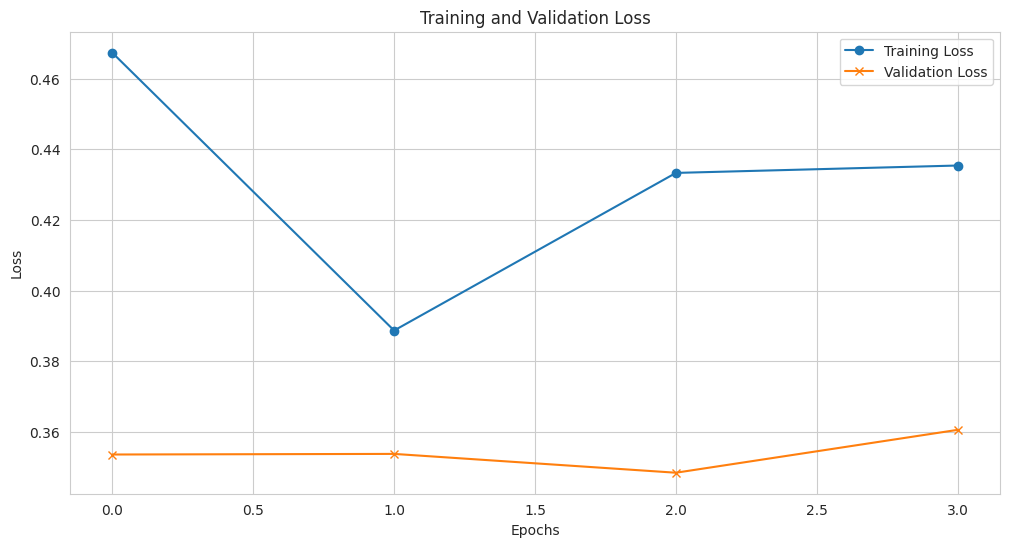

In [ ]:
plt.figure(figsize=(12, 6))
#plt.subplot(1, 2, 1)
plt.plot(trans_history.history['loss'], label='Training Loss', marker='o')
plt.plot(trans_history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/content/uvss_Trans_Loss.png", format="png", dpi=300)

plt.show()

In [ ]:
print('Training Loss: ', trans_history.history['loss'])
print('Validiation Loss: ', trans_history.history['val_loss'])

Training Loss:  [0.4673921465873718, 0.3886682391166687, 0.4333316385746002, 0.4354249835014343]
Validiation Loss:  [0.35352787375450134, 0.3537001311779022, 0.3483668565750122, 0.3605201244354248]


In [ ]:
del transformer_model,trans_history

In [ ]:
del univariate_data, univariate_future_target, univariate_past_history

In [ ]:
del train_univariate, val_univariate

# **Multi-Step model**
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

In [7]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [8]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_considered]
features.index = df['Date Time']
features.head()

dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)   # Axis 0 will act on all the ROWS in each COLUMN
                                                 # Axis 1 will act on all the COLUMNS in each ROW
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

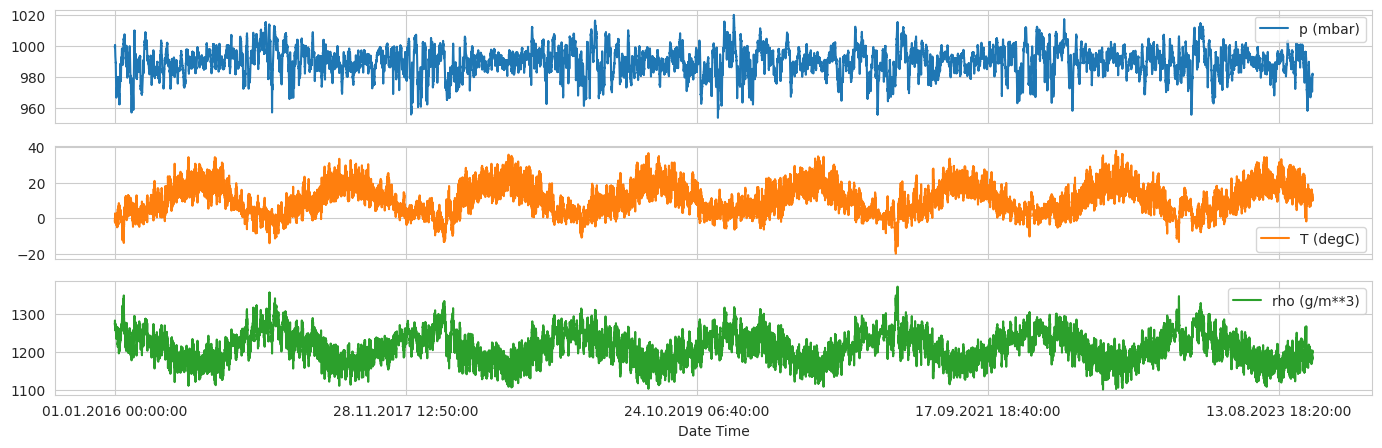

In [ ]:
features.plot(subplots=True)
plt.savefig("3variate sample.png", format="png", dpi=300)

**Univariate Window size 432 (3 days past data) and predictions for the next 12 hrs.**

In [ ]:
del x_train_multi, y_train_multi, train_data_multi, val_data_multi

In [9]:
past_history = 432
future_target = 72
STEP = 6

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [10]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [11]:
print(x_train_multi.shape, y_train_multi.shape)

(299568, 72, 3) (299568, 72)


**LSTM**

In [12]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))


# Define custom metrics
custom_metrics = [
    tf.keras.metrics.MeanSquaredError(name='mse'),
    tf.keras.metrics.MeanAbsoluteError(name='mae'),
    # Define a custom MAPE metric
    tf.keras.metrics.MeanAbsolutePercentageError(name='mape')
]

multi_step_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),
    loss='mse',  # Specify one loss for compilation
    metrics=custom_metrics  # Include custom metrics in the compilation
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
multi_step_history = multi_step_model.fit(
    train_data_multi,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_data_multi,
    validation_steps=EVALUATION_INTERVAL,
    callbacks=[early_stopping]
)

# Extract the custom metric values from the history object
mse_loss = multi_step_history.history['mse']
mae_loss = multi_step_history.history['mae']
mape_loss = multi_step_history.history['mape']

for epoch, mse, mae, mape in zip(range(1, len(mse_loss) + 1), mse_loss, mae_loss, mape_loss):
    print(f'Epoch {epoch}: MSE Loss - {mse:.4f}, MAE Loss - {mae:.4f}, MAPE Loss - {mape:.4f}')


Epoch 1/4
200/200 [==============================] - 23s 93ms/step - loss: 0.4304 - mse: 0.4304 - mae: 0.4918 - mape: 203.1540 - val_loss: 0.2601 - val_mse: 0.2601 - val_mae: 0.3931 - val_mape: 280.5346
Epoch 2/4
200/200 [==============================] - 18s 88ms/step - loss: 0.1930 - mse: 0.1930 - mae: 0.3440 - mape: 325.7199 - val_loss: 0.2289 - val_mse: 0.2289 - val_mae: 0.3710 - val_mape: 259.2850
Epoch 3/4
200/200 [==============================] - 18s 88ms/step - loss: 0.1857 - mse: 0.1857 - mae: 0.3371 - mape: 289.2416 - val_loss: 0.1602 - val_mse: 0.1602 - val_mae: 0.3126 - val_mape: 200.5999
Epoch 4/4
200/200 [==============================] - 18s 89ms/step - loss: 0.1242 - mse: 0.1242 - mae: 0.2736 - mape: 210.8054 - val_loss: 0.1159 - val_mse: 0.1159 - val_mae: 0.2620 - val_mape: 175.8066
Epoch 1: MSE Loss - 0.4304, MAE Loss - 0.4918, MAPE Loss - 203.1540
Epoch 2: MSE Loss - 0.1930, MAE Loss - 0.3440, MAPE Loss - 325.7199
Epoch 3: MSE Loss - 0.1857, MAE Loss - 0.3371, MAPE 

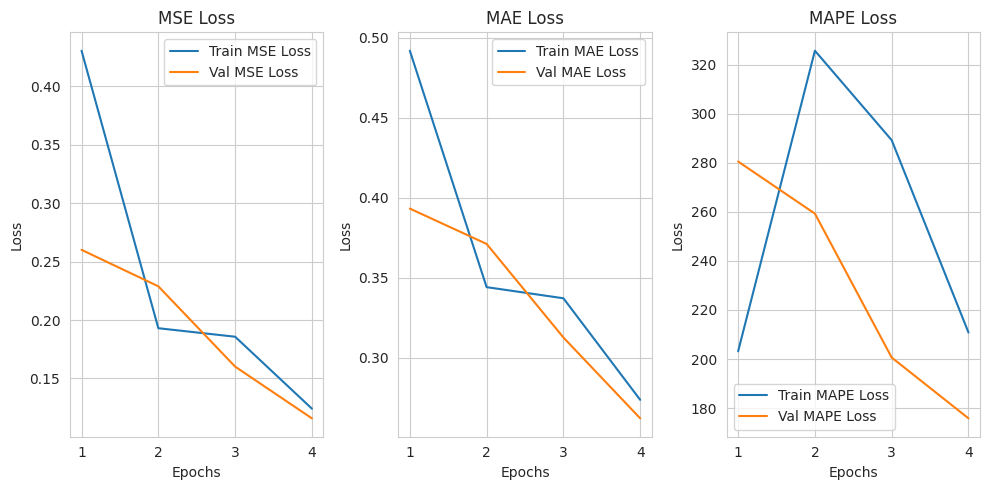

In [13]:
import matplotlib.pyplot as plt

# Extract the loss values from the history object
train_mse_loss = multi_step_history.history['mse']
train_mae_loss = multi_step_history.history['mae']
train_mape_loss = multi_step_history.history['mape']

val_mse_loss = multi_step_history.history['val_mse']
val_mae_loss = multi_step_history.history['val_mae']
val_mape_loss = multi_step_history.history['val_mape']

# Create a figure with subplots for each loss function (training and validation)
plt.figure(figsize=(10, 5))

# Plot MSE Loss
plt.subplot(131)
plt.plot(range(1, len(train_mse_loss) + 1), train_mse_loss, label='Train MSE Loss')
plt.plot(range(1, len(val_mse_loss) + 1), val_mse_loss, label='Val MSE Loss')
plt.title('MSE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE Loss
plt.subplot(132)
plt.plot(range(1, len(train_mae_loss) + 1), train_mae_loss, label='Train MAE Loss')
plt.plot(range(1, len(val_mae_loss) + 1), val_mae_loss, label='Val MAE Loss')
plt.title('MAE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot MAPE Loss
plt.subplot(133)
plt.plot(range(1, len(train_mape_loss) + 1), train_mape_loss, label='Train MAPE Loss')
plt.plot(range(1, len(val_mape_loss) + 1), val_mape_loss, label='Val MAPE Loss')
plt.title('MAPE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Adjust layout for better visualization
plt.tight_layout()

plt.savefig('720-6-lstm_loss.png', format='png', dpi=300)
# Show the plot
plt.show()


8/8 [==============================] - 0s 12ms/step


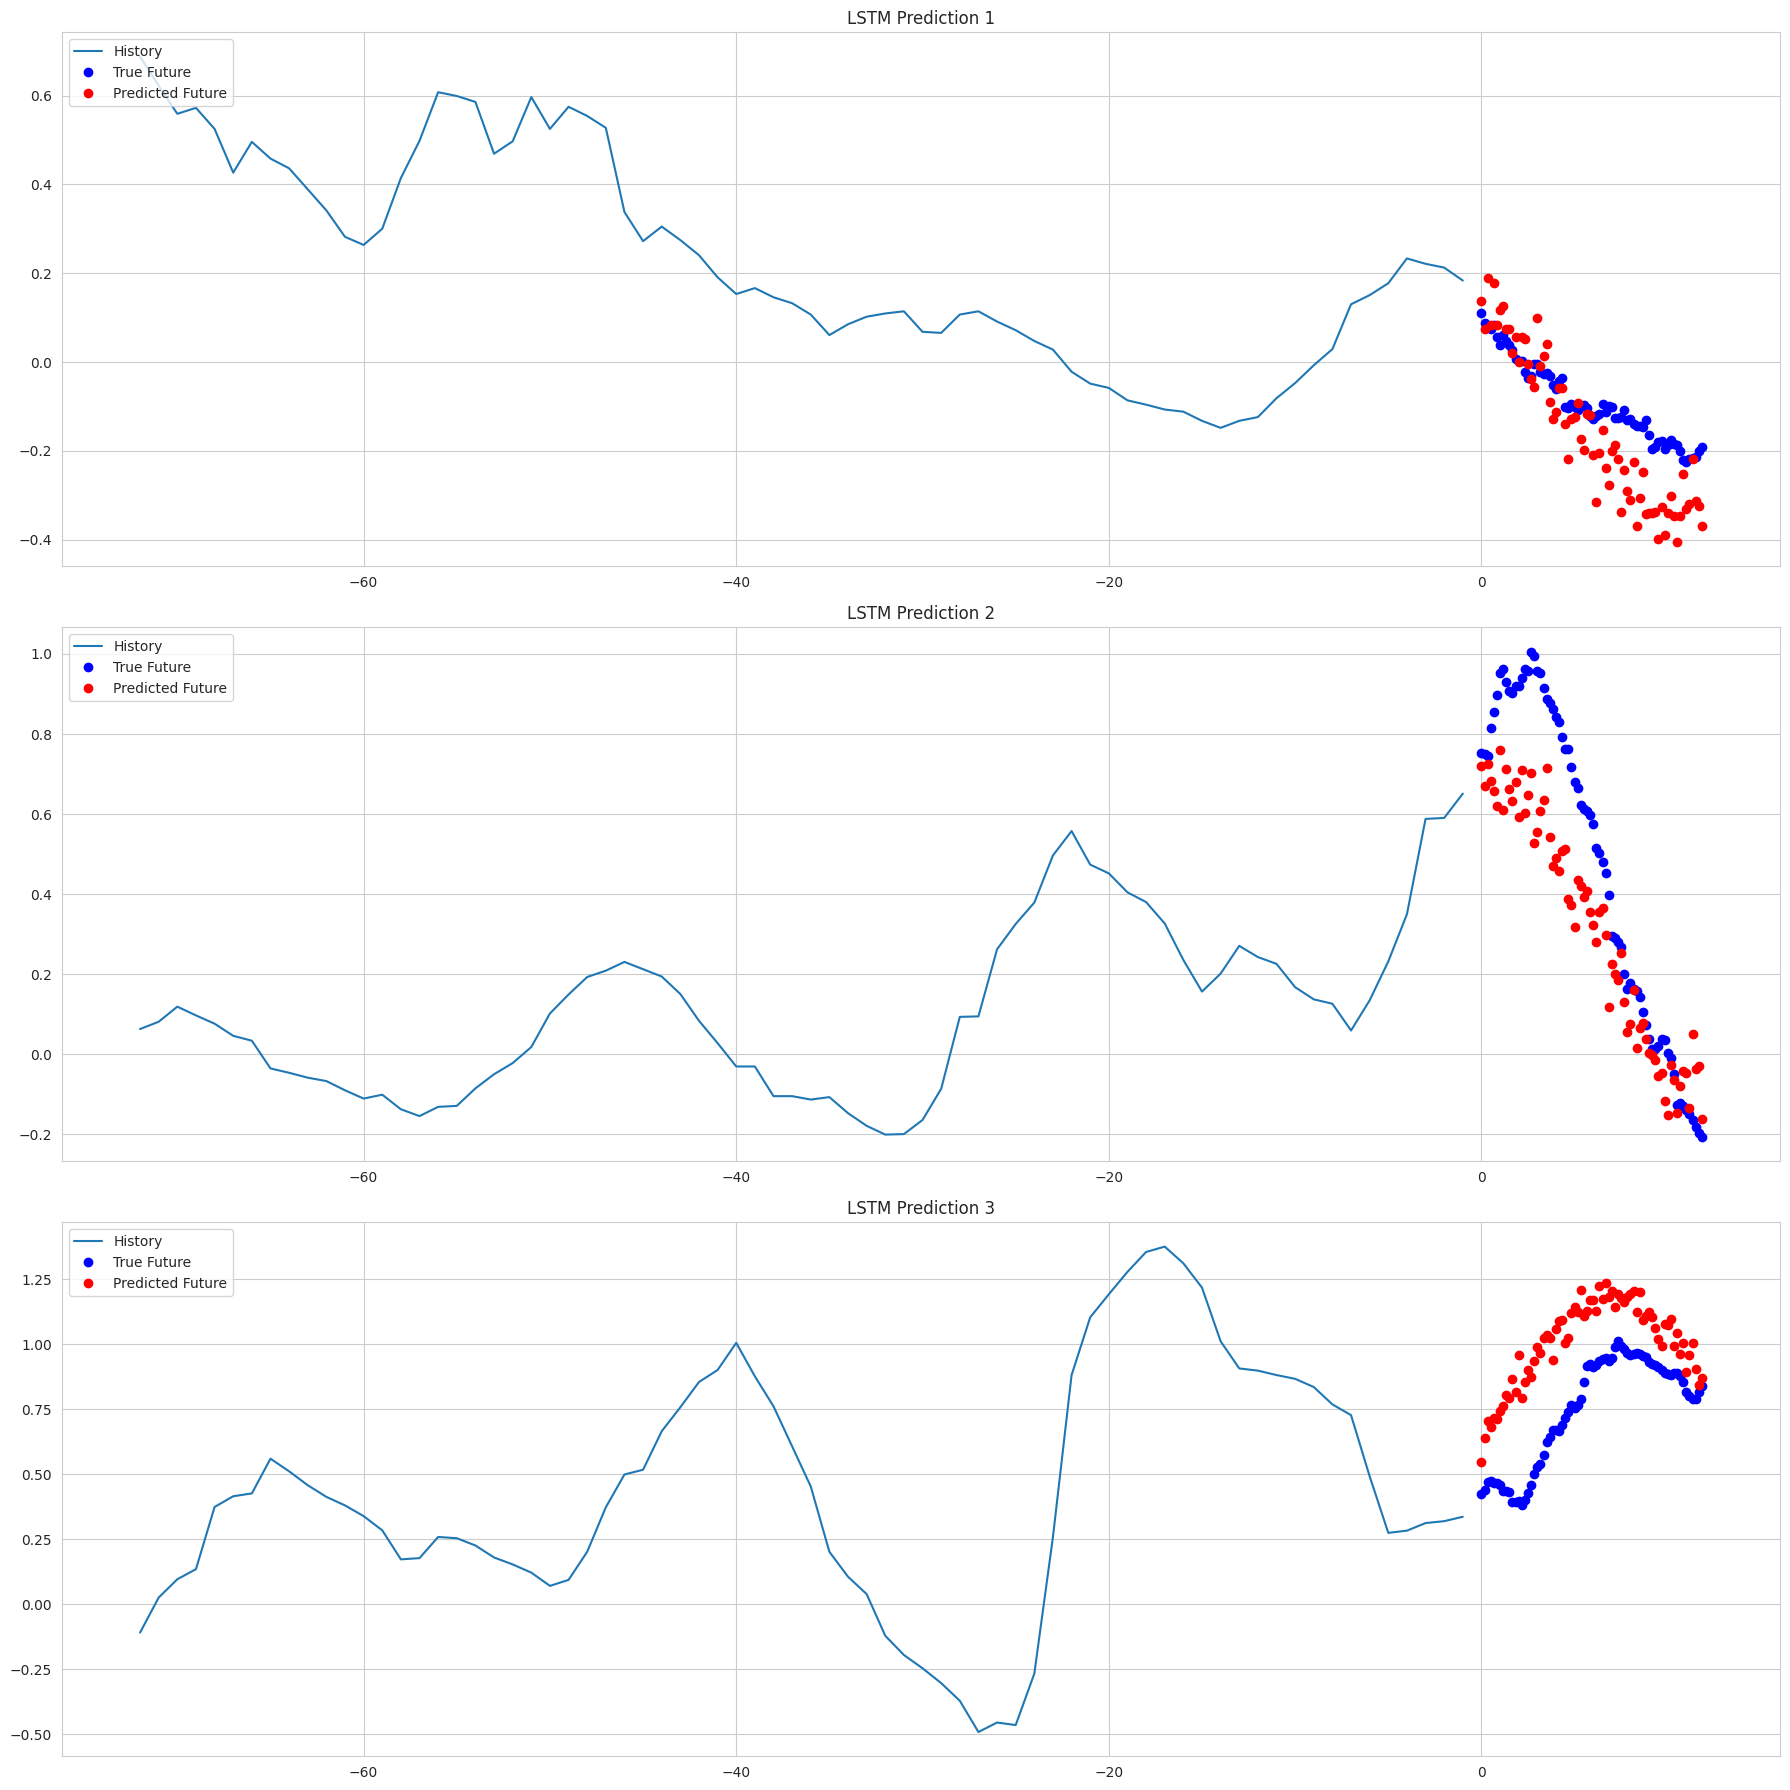

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction, title=""):
    plt.plot(create_time_steps(len(history)), np.array(history[:, 1]), label='History')
    plt.plot(np.arange(len(true_future))/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(len(prediction))/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.title(title)
    plt.legend(loc='upper left')

# Create a figure for all three subplots
plt.figure(figsize=(18, 18))

# Assuming the following loop is part of your code
for i, (x, y) in enumerate(val_data_multi.take(3)):
    prediction = multi_step_model.predict(x)[0]
    plt.subplot(3, 1, i+1)
    multi_step_plot(x[0], y[0], prediction, title=f'LSTM Prediction {i+1}')

# Adjust layout for better visualization
plt.tight_layout()

# Save the figure as a single file
plt.savefig('432-6-72-LSTM.png', format='png', dpi=300)

# Show the plot
plt.show()


In [15]:
del   multi_step_history, multi_step_model
_ = gc.collect()

In [ ]:
del tcn_history, tcn_model
_ = gc.collect()

# **Temperoal Convolution Network Model**

In [16]:
pip install tensorflow-addons --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.6 MB/s eta 0:00:00


In [ ]:
pip install keras-tcn

In [21]:
from tcn import TCN
from tensorflow.keras.layers import InputLayer

# Define the TCN model
tcn_model = tf.keras.models.Sequential([
    InputLayer(input_shape=x_train_multi.shape[-2:]),
    TCN(nb_filters=32, kernel_size=3, dropout_rate=0.2),
    tf.keras.layers.Flatten(),  # Use Flatten instead of GlobalAveragePooling1D
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(72)
])

# Define custom metrics
custom_metrics = [
    tf.keras.metrics.MeanSquaredError(name='mse'),
    tf.keras.metrics.MeanAbsoluteError(name='mae'),
    # Define a custom MAPE metric
    tf.keras.metrics.MeanAbsolutePercentageError(name='mape')
]

# Compile the model with custom metrics
tcn_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),
    loss='mse',
    metrics=custom_metrics
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Train the TCN model
tcn_history = tcn_model.fit(
    train_data_multi,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_data_multi,
    validation_steps=EVALUATION_INTERVAL,
    callbacks=[early_stopping]
)

# Extract the custom metric values from the history object
tcn_mse_loss = tcn_history.history['mse']
tcn_mae_loss = tcn_history.history['mae']
tcn_mape_loss = tcn_history.history['mape']

for epoch, mse, mae, mape in zip(range(1, len(tcn_mse_loss) + 1), tcn_mse_loss, tcn_mae_loss, tcn_mape_loss):
    print(f'Epoch {epoch}: MSE Loss - {mse:.4f}, MAE Loss - {mae:.4f}, MAPE Loss - {mape:.4f}')


Epoch 1/4
200/200 [==============================] - 8s 19ms/step - loss: 1.4344 - mse: 1.4344 - mae: 0.8846 - mape: 151.7512 - val_loss: 0.8627 - val_mse: 0.8627 - val_mae: 0.7356 - val_mape: 147.9534
Epoch 2/4
200/200 [==============================] - 3s 16ms/step - loss: 0.3729 - mse: 0.3729 - mae: 0.4361 - mape: 242.1604 - val_loss: 0.1485 - val_mse: 0.1485 - val_mae: 0.2954 - val_mape: 203.6661
Epoch 3/4
200/200 [==============================] - 3s 16ms/step - loss: 0.1241 - mse: 0.1241 - mae: 0.2705 - mape: 205.0782 - val_loss: 0.0976 - val_mse: 0.0976 - val_mae: 0.2391 - val_mape: 164.5625
Epoch 4/4
200/200 [==============================] - 3s 16ms/step - loss: 0.1008 - mse: 0.1008 - mae: 0.2421 - mape: 185.7099 - val_loss: 0.0883 - val_mse: 0.0883 - val_mae: 0.2240 - val_mape: 156.8887
Epoch 1: MSE Loss - 1.4344, MAE Loss - 0.8846, MAPE Loss - 151.7512
Epoch 2: MSE Loss - 0.3729, MAE Loss - 0.4361, MAPE Loss - 242.1604
Epoch 3: MSE Loss - 0.1241, MAE Loss - 0.2705, MAPE Loss

In [24]:
del tcn_model, tcn_history

In [25]:
from tcn import TCN
from tensorflow.keras.layers import InputLayer

# Define the TCN model
tcn_model = tf.keras.models.Sequential([
    InputLayer(input_shape=x_train_multi.shape[-2:]),
    TCN(nb_filters=32, kernel_size=3, dropout_rate=0.2),
    tf.keras.layers.Flatten(),  # Use Flatten instead of GlobalAveragePooling1D
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(72)
])

# Define custom metrics
custom_metrics = [
    tf.keras.metrics.MeanSquaredError(name='mse'),
    tf.keras.metrics.MeanAbsoluteError(name='mae'),
    # Define a custom MAPE metric
    tf.keras.metrics.MeanAbsolutePercentageError(name='mape')
]

# Compile the model with custom metrics
tcn_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0,learning_rate=0.004 ),
    loss='mse',
    metrics=custom_metrics
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Train the TCN model
tcn_history = tcn_model.fit(
    train_data_multi,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_data_multi,
    validation_steps=EVALUATION_INTERVAL,
    callbacks=[early_stopping]
)

# Extract the custom metric values from the history object
tcn_mse_loss = tcn_history.history['mse']
tcn_mae_loss = tcn_history.history['mae']
tcn_mape_loss = tcn_history.history['mape']

for epoch, mse, mae, mape in zip(range(1, len(tcn_mse_loss) + 1), tcn_mse_loss, tcn_mae_loss, tcn_mape_loss):
    print(f'Epoch {epoch}: MSE Loss - {mse:.4f}, MAE Loss - {mae:.4f}, MAPE Loss - {mape:.4f}')


Epoch 1/4
200/200 [==============================] - 9s 21ms/step - loss: 0.4251 - mse: 0.4251 - mae: 0.4242 - mape: 253.6794 - val_loss: 0.1614 - val_mse: 0.1614 - val_mae: 0.3134 - val_mape: 230.3425
Epoch 2/4
200/200 [==============================] - 4s 18ms/step - loss: 0.1245 - mse: 0.1245 - mae: 0.2719 - mape: 241.4457 - val_loss: 0.1116 - val_mse: 0.1116 - val_mae: 0.2531 - val_mape: 163.9782
Epoch 3/4
200/200 [==============================] - 4s 18ms/step - loss: 0.1213 - mse: 0.1213 - mae: 0.2672 - mape: 190.0363 - val_loss: 0.0962 - val_mse: 0.0962 - val_mae: 0.2383 - val_mape: 140.7239
Epoch 4/4
200/200 [==============================] - 4s 18ms/step - loss: 0.1066 - mse: 0.1066 - mae: 0.2509 - mape: 192.4294 - val_loss: 0.1138 - val_mse: 0.1138 - val_mae: 0.2587 - val_mape: 182.7690
Epoch 1: MSE Loss - 0.4251, MAE Loss - 0.4242, MAPE Loss - 253.6794
Epoch 2: MSE Loss - 0.1245, MAE Loss - 0.2719, MAPE Loss - 241.4457
Epoch 3: MSE Loss - 0.1213, MAE Loss - 0.2672, MAPE Loss

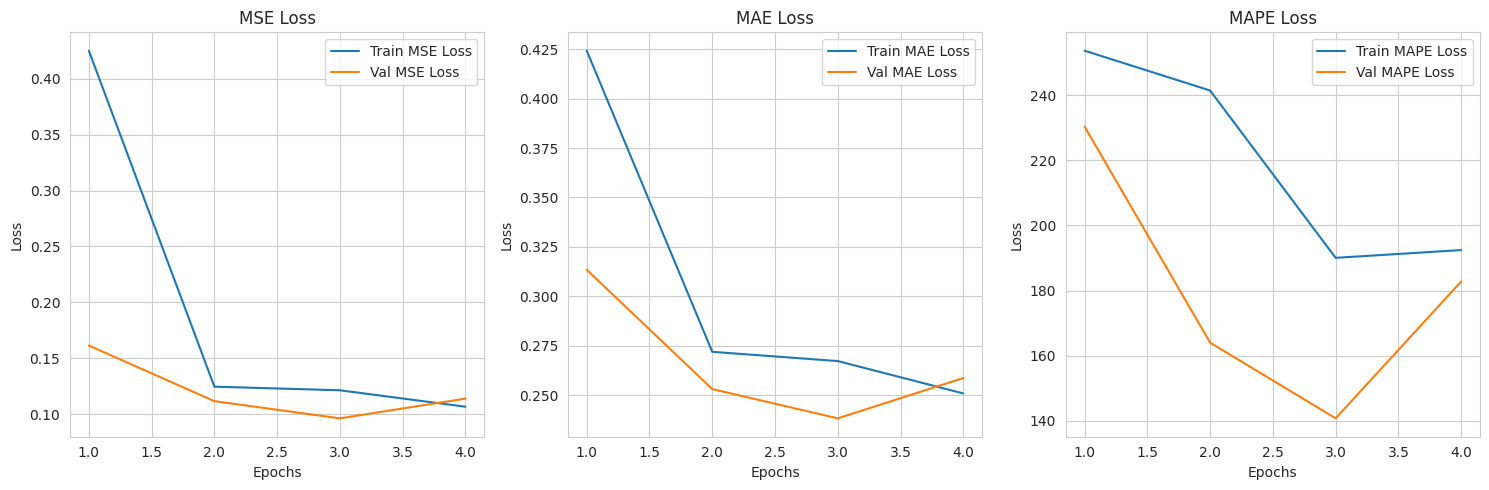

In [26]:
import matplotlib.pyplot as plt

# Extract the loss values from the history object
train_mse_loss = tcn_history.history['mse']
train_mae_loss = tcn_history.history['mae']
train_mape_loss = tcn_history.history['mape']

val_mse_loss = tcn_history.history['val_mse']
val_mae_loss = tcn_history.history['val_mae']
val_mape_loss = tcn_history.history['val_mape']

# Create a figure with subplots for each loss function (training and validation)
plt.figure(figsize=(15, 5))

# Plot MSE Loss
plt.subplot(131)
plt.plot(range(1, len(train_mse_loss) + 1), train_mse_loss, label='Train MSE Loss')
plt.plot(range(1, len(val_mse_loss) + 1), val_mse_loss, label='Val MSE Loss')
plt.title('MSE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE Loss
plt.subplot(132)
plt.plot(range(1, len(train_mae_loss) + 1), train_mae_loss, label='Train MAE Loss')
plt.plot(range(1, len(val_mae_loss) + 1), val_mae_loss, label='Val MAE Loss')
plt.title('MAE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAPE Loss
plt.subplot(133)
plt.plot(range(1, len(train_mape_loss) + 1), train_mape_loss, label='Train MAPE Loss')
plt.plot(range(1, len(val_mape_loss) + 1), val_mape_loss, label='Val MAPE Loss')
plt.title('MAPE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Adjust layout for better visualization
plt.tight_layout()

plt.savefig('432-6-72-TCN_loss.png', format='png', dpi=300)
# Show the plot
plt.show()

8/8 [==============================] - 0s 3ms/step


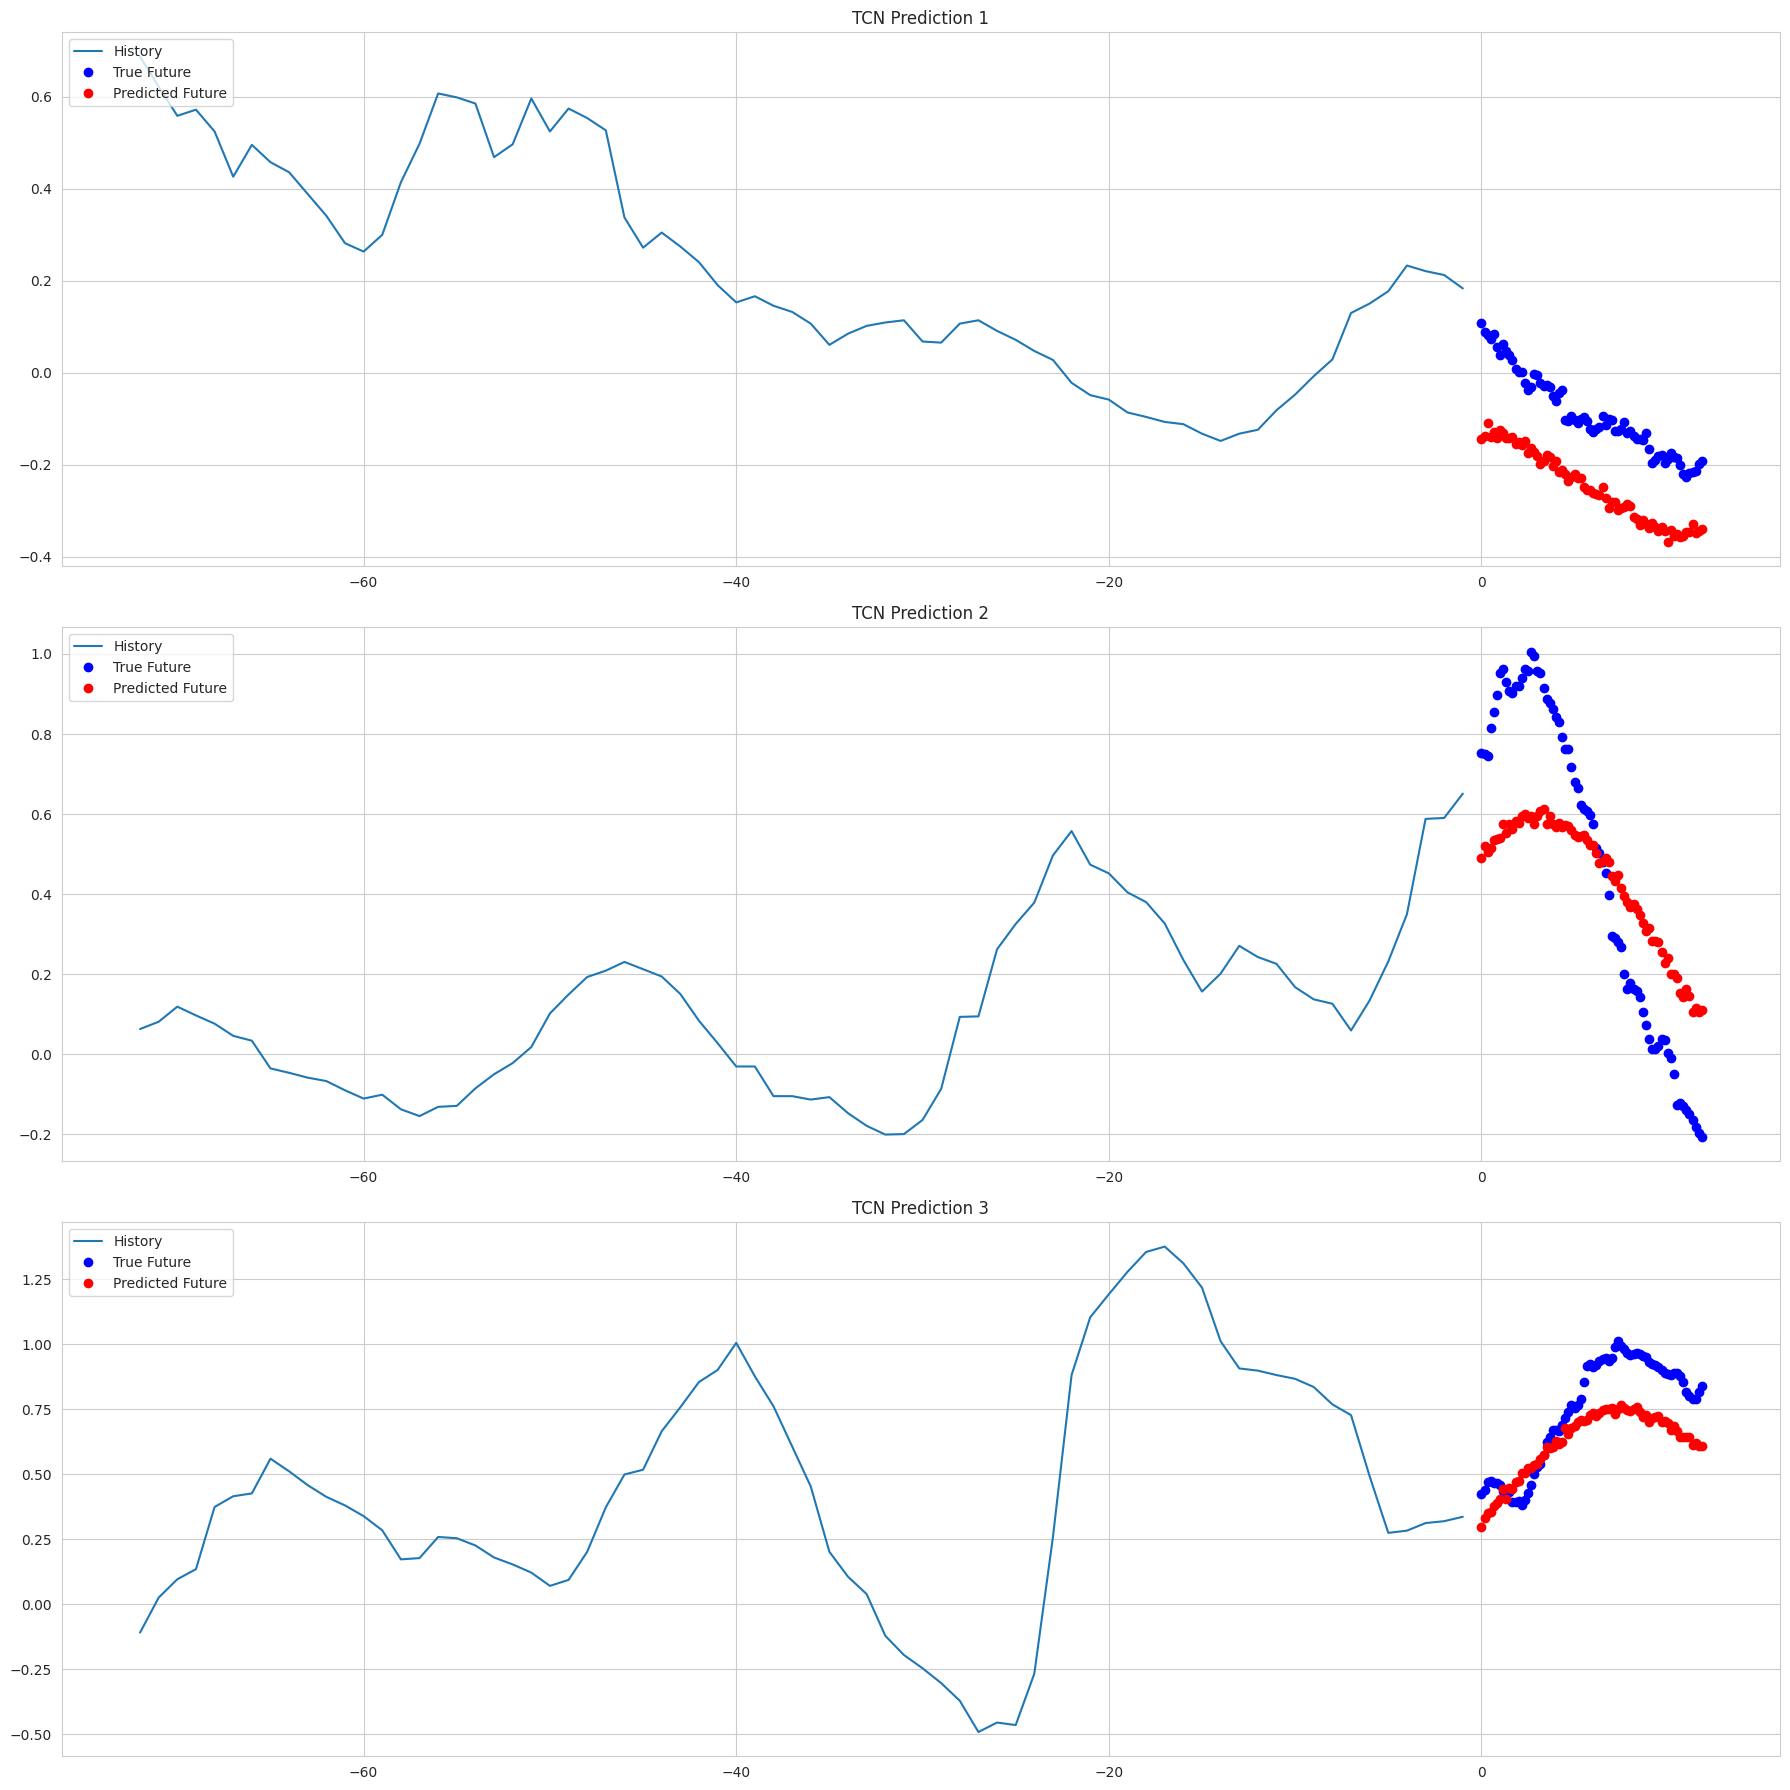

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction, title=""):
    plt.plot(create_time_steps(len(history)), np.array(history[:, 1]), label='History')
    plt.plot(np.arange(len(true_future))/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(len(prediction))/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.title(title)
    plt.legend(loc='upper left')

# Create a figure for all three subplots
plt.figure(figsize=(18, 18))

# Assuming the following loop is part of your code
for i, (x, y) in enumerate(val_data_multi.take(3)):
    prediction = tcn_model.predict(x)[0]
    plt.subplot(3, 1, i+1)
    multi_step_plot(x[0], y[0], prediction, title=f'TCN Prediction {i+1}')

# Adjust layout for better visualization
plt.tight_layout()

# Save the figure as a single file
plt.savefig('432-6-72-TCN.png', format='png', dpi=300)

# Show the plot
plt.show()

In [ ]:
del model, history

# **MS-CLSTM**

In [ ]:
del x_train_multi, y_train_multi, x_val_multi, y_val_multi,train_data_multi,val_data_multi

In [ ]:
pip install --upgrade tensorflow


In [ ]:
import keras
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Dense, Flatten, InputLayer, Reshape, Dropout, RepeatVector, TimeDistributed

# Build MS-CLSTM model
def build_model(input_timesteps, output_timesteps, num_links, num_inputs):
    model = Sequential()
    model.add(BatchNormalization(name='batch_norm_0', input_shape=(input_timesteps, num_inputs, 1, 1)))


    model.add(ConvLSTM2D(name='conv_lstm_1',
                         filters=64, kernel_size=(10, 1),
                         padding='same',
                         return_sequences=True))
    model.add(Dropout(0.3, name='dropout_1'))
    model.add(BatchNormalization(name='batch_norm_1'))

    model.add(ConvLSTM2D(name='conv_lstm_2',
                         filters=64, kernel_size=(5, 1),
                         padding='same',
                         return_sequences=False))
    model.add(Dropout(0.2, name='dropout_2'))
    model.add(BatchNormalization(name='batch_norm_2'))

    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))

    model.add(ConvLSTM2D(name='conv_lstm_3',
                         filters=64, kernel_size=(10, 1),
                         padding='same',
                         return_sequences=True))
    model.add(Dropout(0.2, name='dropout_3'))
    model.add(BatchNormalization(name='batch_norm_3'))

    model.add(ConvLSTM2D(name='conv_lstm_4',
                         filters=64, kernel_size=(5, 1),
                         padding='same',
                         return_sequences=True))

    model.add(TimeDistributed(Dense(units=1, name='dense_1', activation='relu')))
    model.add(Dense(units=1, name='dense_2', activation='linear'))

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.004, clipvalue=1.0)
    model.compile(loss="mse", optimizer=optimizer, metrics=['mae', 'mse'])
    return model

model = build_model(x_train_multi.shape[1], future_target, y_train_multi.shape[1], x_train_multi.shape[2])


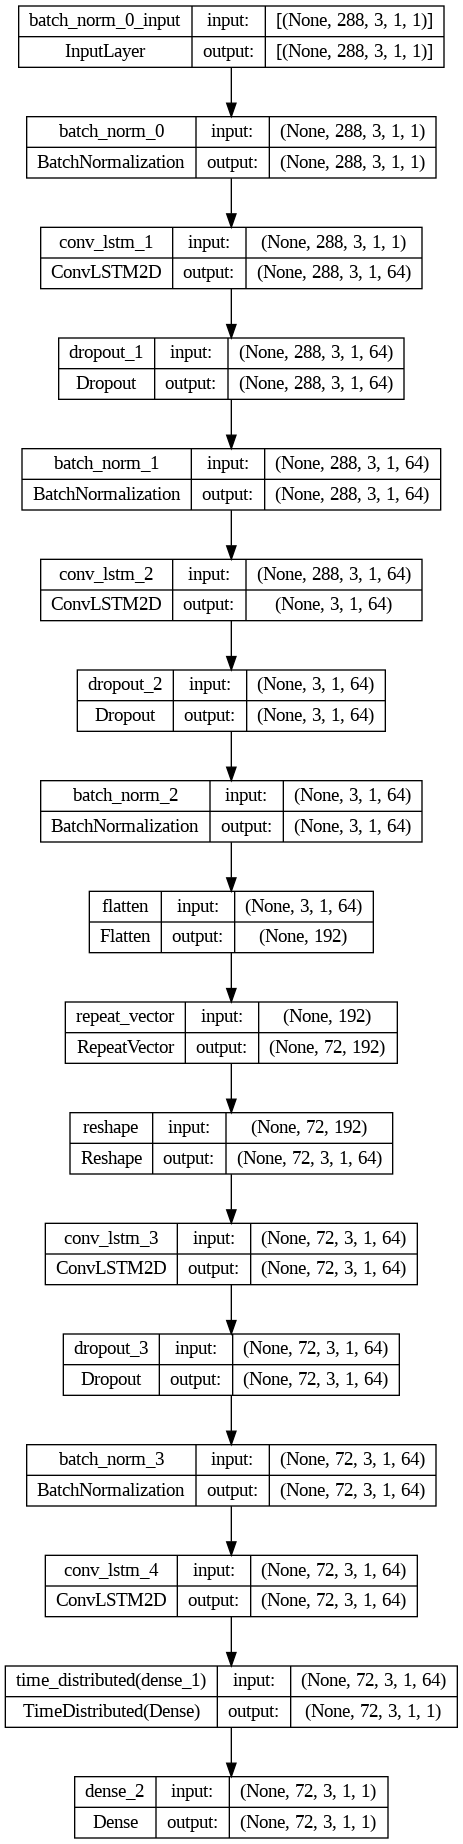

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the TCN model
model_history = model.fit(
    train_data_multi,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_data_multi,
    validation_steps=EVALUATION_INTERVAL,
    callbacks=[early_stopping]
)

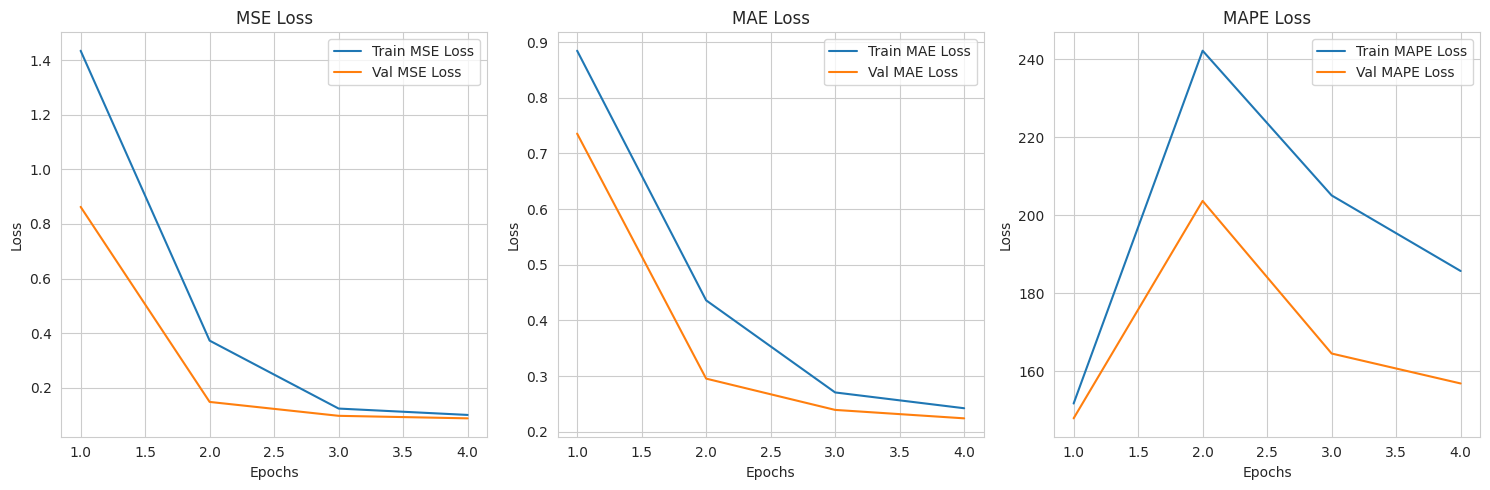

In [22]:
import matplotlib.pyplot as plt

# Extract the loss values from the history object
train_mse_loss = model_history.history['mse']
train_mae_loss = model_history.history['mae']
train_mape_loss = model_history.history['mape']

val_mse_loss = model_history.history['val_mse']
val_mae_loss = model_history.history['val_mae']
val_mape_loss = model_history.history['val_mape']

# Create a figure with subplots for each loss function (training and validation)
plt.figure(figsize=(15, 5))

# Plot MSE Loss
plt.subplot(131)
plt.plot(range(1, len(train_mse_loss) + 1), train_mse_loss, label='Train MSE Loss')
plt.plot(range(1, len(val_mse_loss) + 1), val_mse_loss, label='Val MSE Loss')
plt.title('MSE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE Loss
plt.subplot(132)
plt.plot(range(1, len(train_mae_loss) + 1), train_mae_loss, label='Train MAE Loss')
plt.plot(range(1, len(val_mae_loss) + 1), val_mae_loss, label='Val MAE Loss')
plt.title('MAE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAPE Loss
plt.subplot(133)
plt.plot(range(1, len(train_mape_loss) + 1), train_mape_loss, label='Train MAPE Loss')
plt.plot(range(1, len(val_mape_loss) + 1), val_mape_loss, label='Val MAPE Loss')
plt.title('MAPE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Adjust layout for better visualization
plt.tight_layout()

plt.savefig('432-6-72-msclstm_loss.png', format='png', dpi=300)
# Show the plot
plt.show()

8/8 [==============================] - 0s 3ms/step


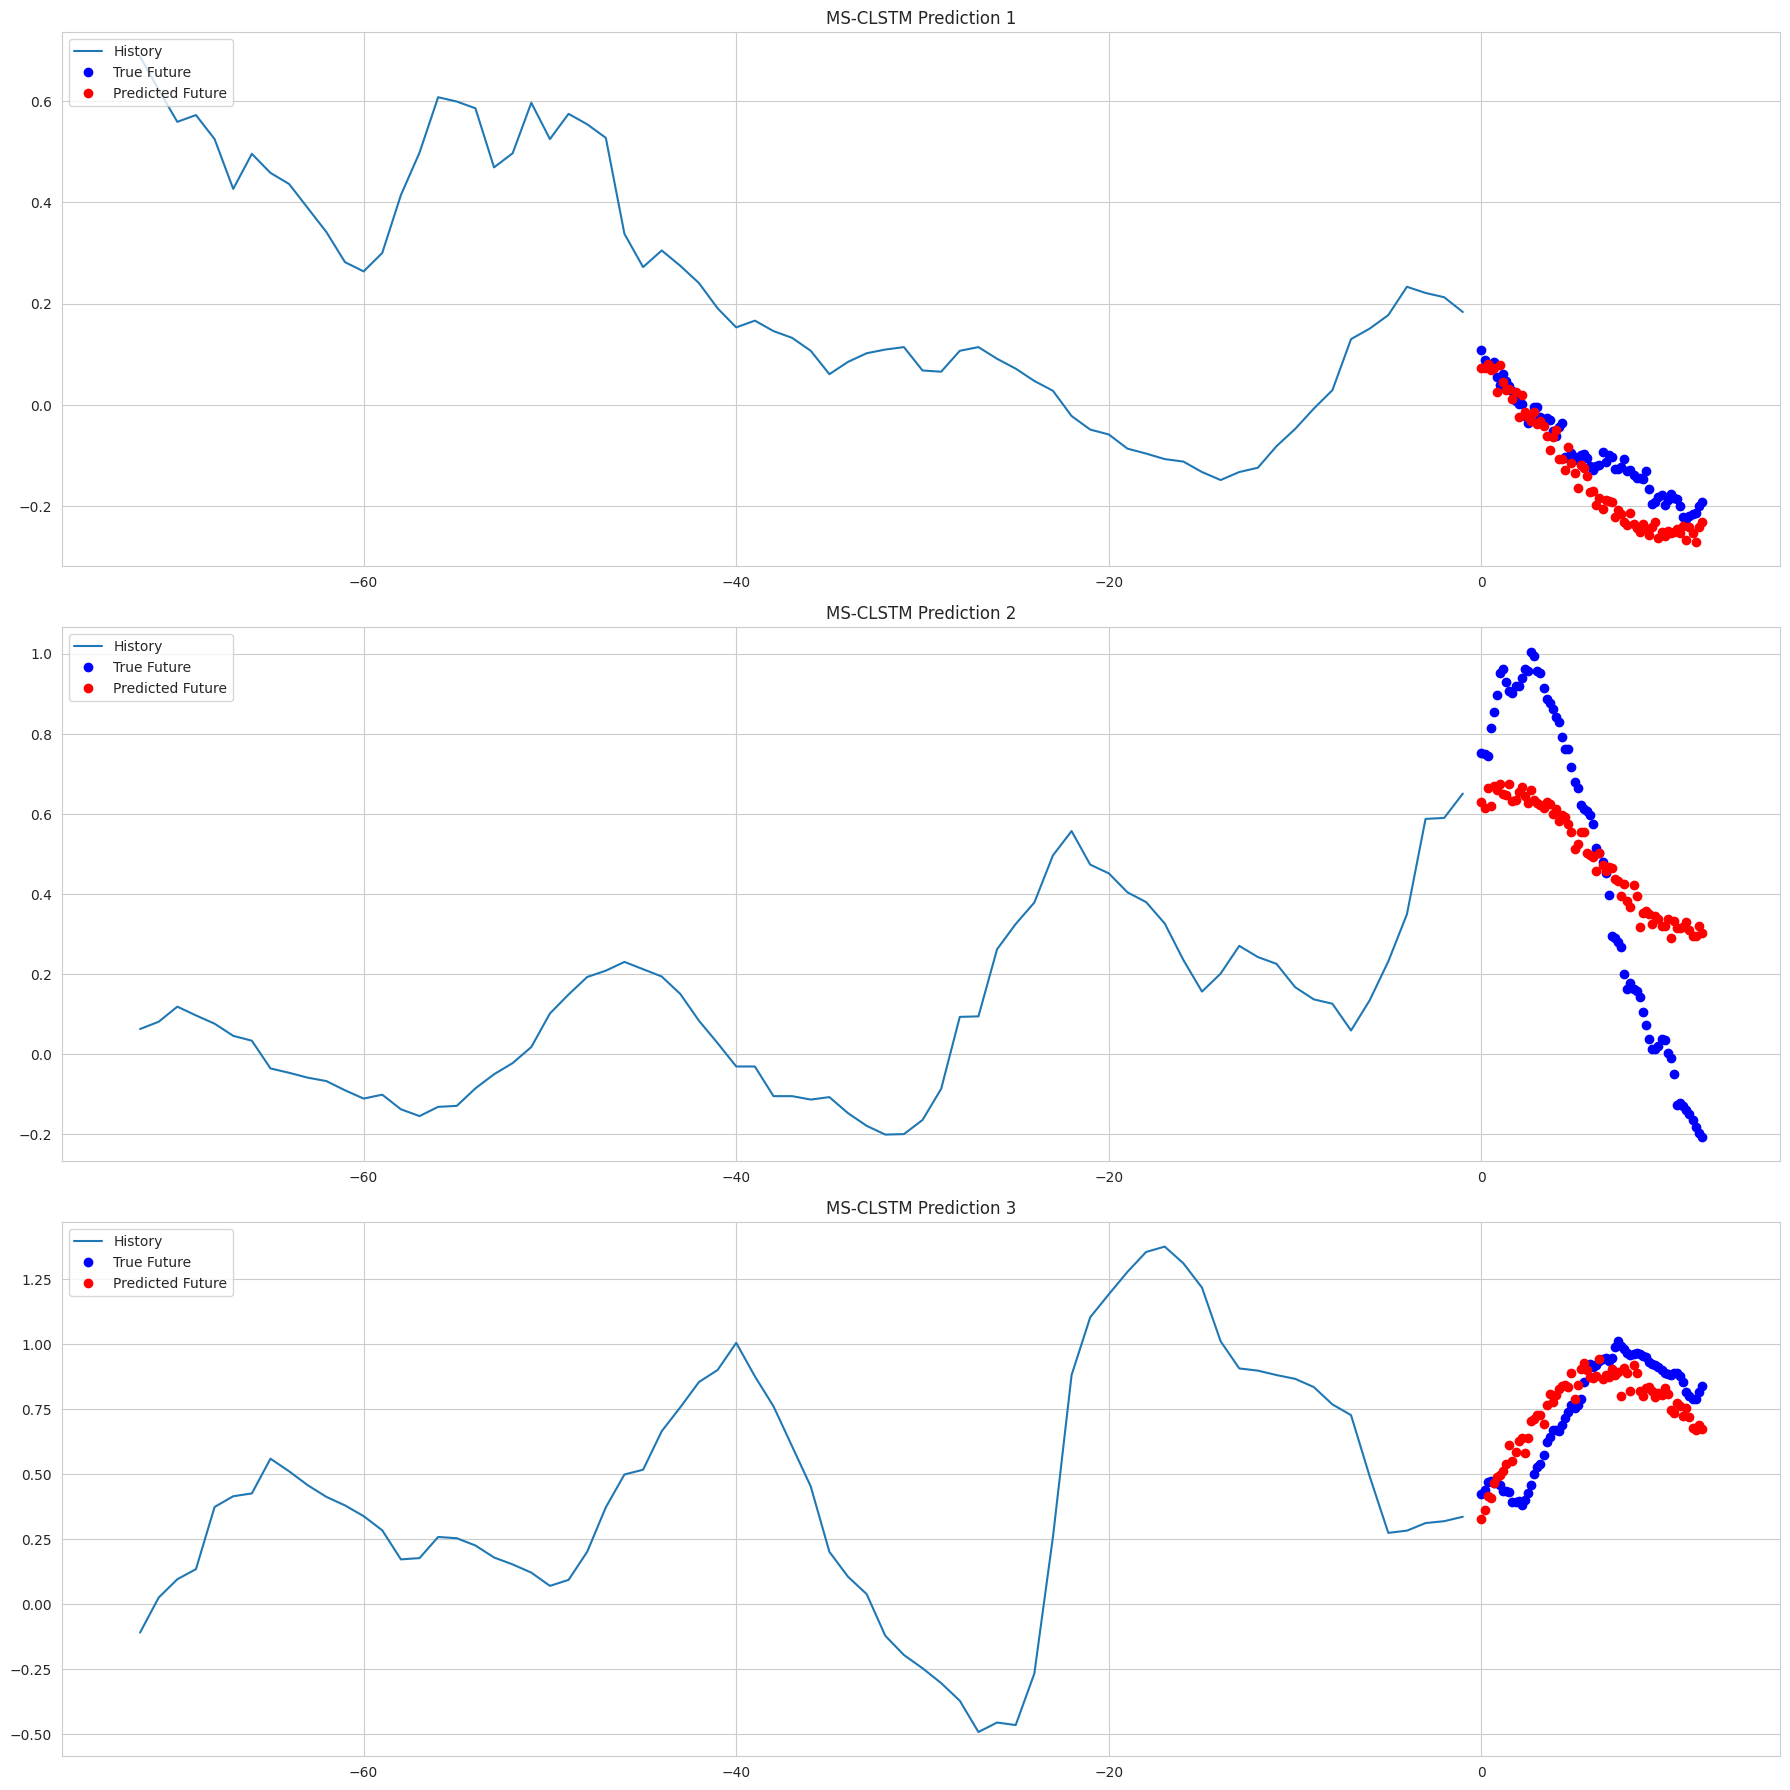

In [23]:
import matplotlib.pyplot as plt   #tcn to be replaced with msclstm
import numpy as np

def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction, title=""):
    plt.plot(create_time_steps(len(history)), np.array(history[:, 1]), label='History')
    plt.plot(np.arange(len(true_future))/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(len(prediction))/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.title(title)
    plt.legend(loc='upper left')

# Create a figure for all three subplots
plt.figure(figsize=(18, 18))

# Assuming the following loop is part of your code
for i, (x, y) in enumerate(val_data_multi.take(3)):
    prediction = model.predict(x)[0]
    plt.subplot(3, 1, i+1)
    multi_step_plot(x[0], y[0], prediction, title=f'MS-CLSTM Prediction {i+1}')

# Adjust layout for better visualization
plt.tight_layout()

# Save the figure as a single file
plt.savefig('432-6-72-MS-CLSTM.png', format='png', dpi=300)

# Show the plot
plt.show()

# **Transformer based Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention

# Define the Transformer block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    attn_output = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    ff_output = Dense(ff_dim, activation="relu")(out1)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ff_output)

# Build the Transformer model
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0.1):
    inputs = Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformer_block(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(dropout)(x)
    outputs = Dense(72, activation="linear")(x)

    return Model(inputs=inputs, outputs=outputs)

# Set hyperparameters
head_size = 256
num_heads = 4
ff_dim = 4
num_transformer_blocks = 4
mlp_units = [128]

# Build the Transformer model
trns_model = build_transformer_model(
    input_shape=x_train_multi.shape[-2:],
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    mlp_units=mlp_units,
    dropout=0.1
)

# Define custom metrics
custom_metrics = [
    tf.keras.metrics.MeanSquaredError(name='mse'),
    tf.keras.metrics.MeanAbsoluteError(name='mae'),
    # Define a custom MAPE metric
    tf.keras.metrics.MeanAbsolutePercentageError(name='mape')
]
# Compile the model
#transformer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'mape'])

# Print the model summary
#transformer_model.summary()
# Compile the model with custom metrics
trns_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),
    loss='mse',
    metrics=custom_metrics
)
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
# Train the TCN model
trns_history = trns_model.fit(
    train_data_multi,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_data_multi,
    validation_steps=EVALUATION_INTERVAL,
    callbacks=[early_stopping]
)

# Extract the custom metric values from the history object
tcn_mse_loss = trns_history.history['mse']
tcn_mae_loss = trns_history.history['mae']
tcn_mape_loss = trns_history.history['mape']

for epoch, mse, mae, mape in zip(range(1, len(tcn_mse_loss) + 1), tcn_mse_loss, tcn_mae_loss, tcn_mape_loss):
    print(f'Epoch {epoch}: MSE Loss - {mse:.4f}, MAE Loss - {mae:.4f}, MAPE Loss - {mape:.4f}')


Epoch 1/4


ResourceExhaustedError: ignored

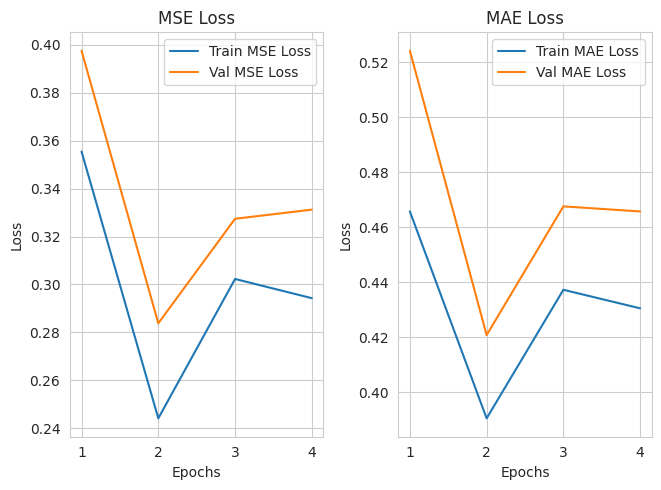

In [ ]:
import matplotlib.pyplot as plt

# Extract the loss values from the history object
train_mse_loss = trns_history.history['mse']
train_mae_loss = trns_history.history['mae']
train_mape_loss = trns_history.history['mape']

val_mse_loss = trns_history.history['val_mse']
val_mae_loss = trns_history.history['val_mae']
val_mape_loss = trns_history.history['val_mape']

# Create a figure with subplots for each loss function (training and validation)
plt.figure(figsize=(10, 5))

# Plot MSE Loss
plt.subplot(131)
plt.plot(range(1, len(train_mse_loss) + 1), train_mse_loss, label='Train MSE Loss')
plt.plot(range(1, len(val_mse_loss) + 1), val_mse_loss, label='Val MSE Loss')
plt.title('MSE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE Loss
plt.subplot(132)
plt.plot(range(1, len(train_mae_loss) + 1), train_mae_loss, label='Train MAE Loss')
plt.plot(range(1, len(val_mae_loss) + 1), val_mae_loss, label='Val MAE Loss')
plt.title('MAE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
'''
# Plot MAPE Loss
plt.subplot(133)
plt.plot(range(1, len(train_mape_loss) + 1), train_mape_loss, label='Train MAPE Loss')
plt.plot(range(1, len(val_mape_loss) + 1), val_mape_loss, label='Val MAPE Loss')
plt.title('MAPE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
'''
# Adjust layout for better visualization
plt.tight_layout()

plt.savefig('432-72-Trans_loss.png', format='png', dpi=300)
# Show the plot
plt.show()

8/8 [==============================] - 0s 11ms/step


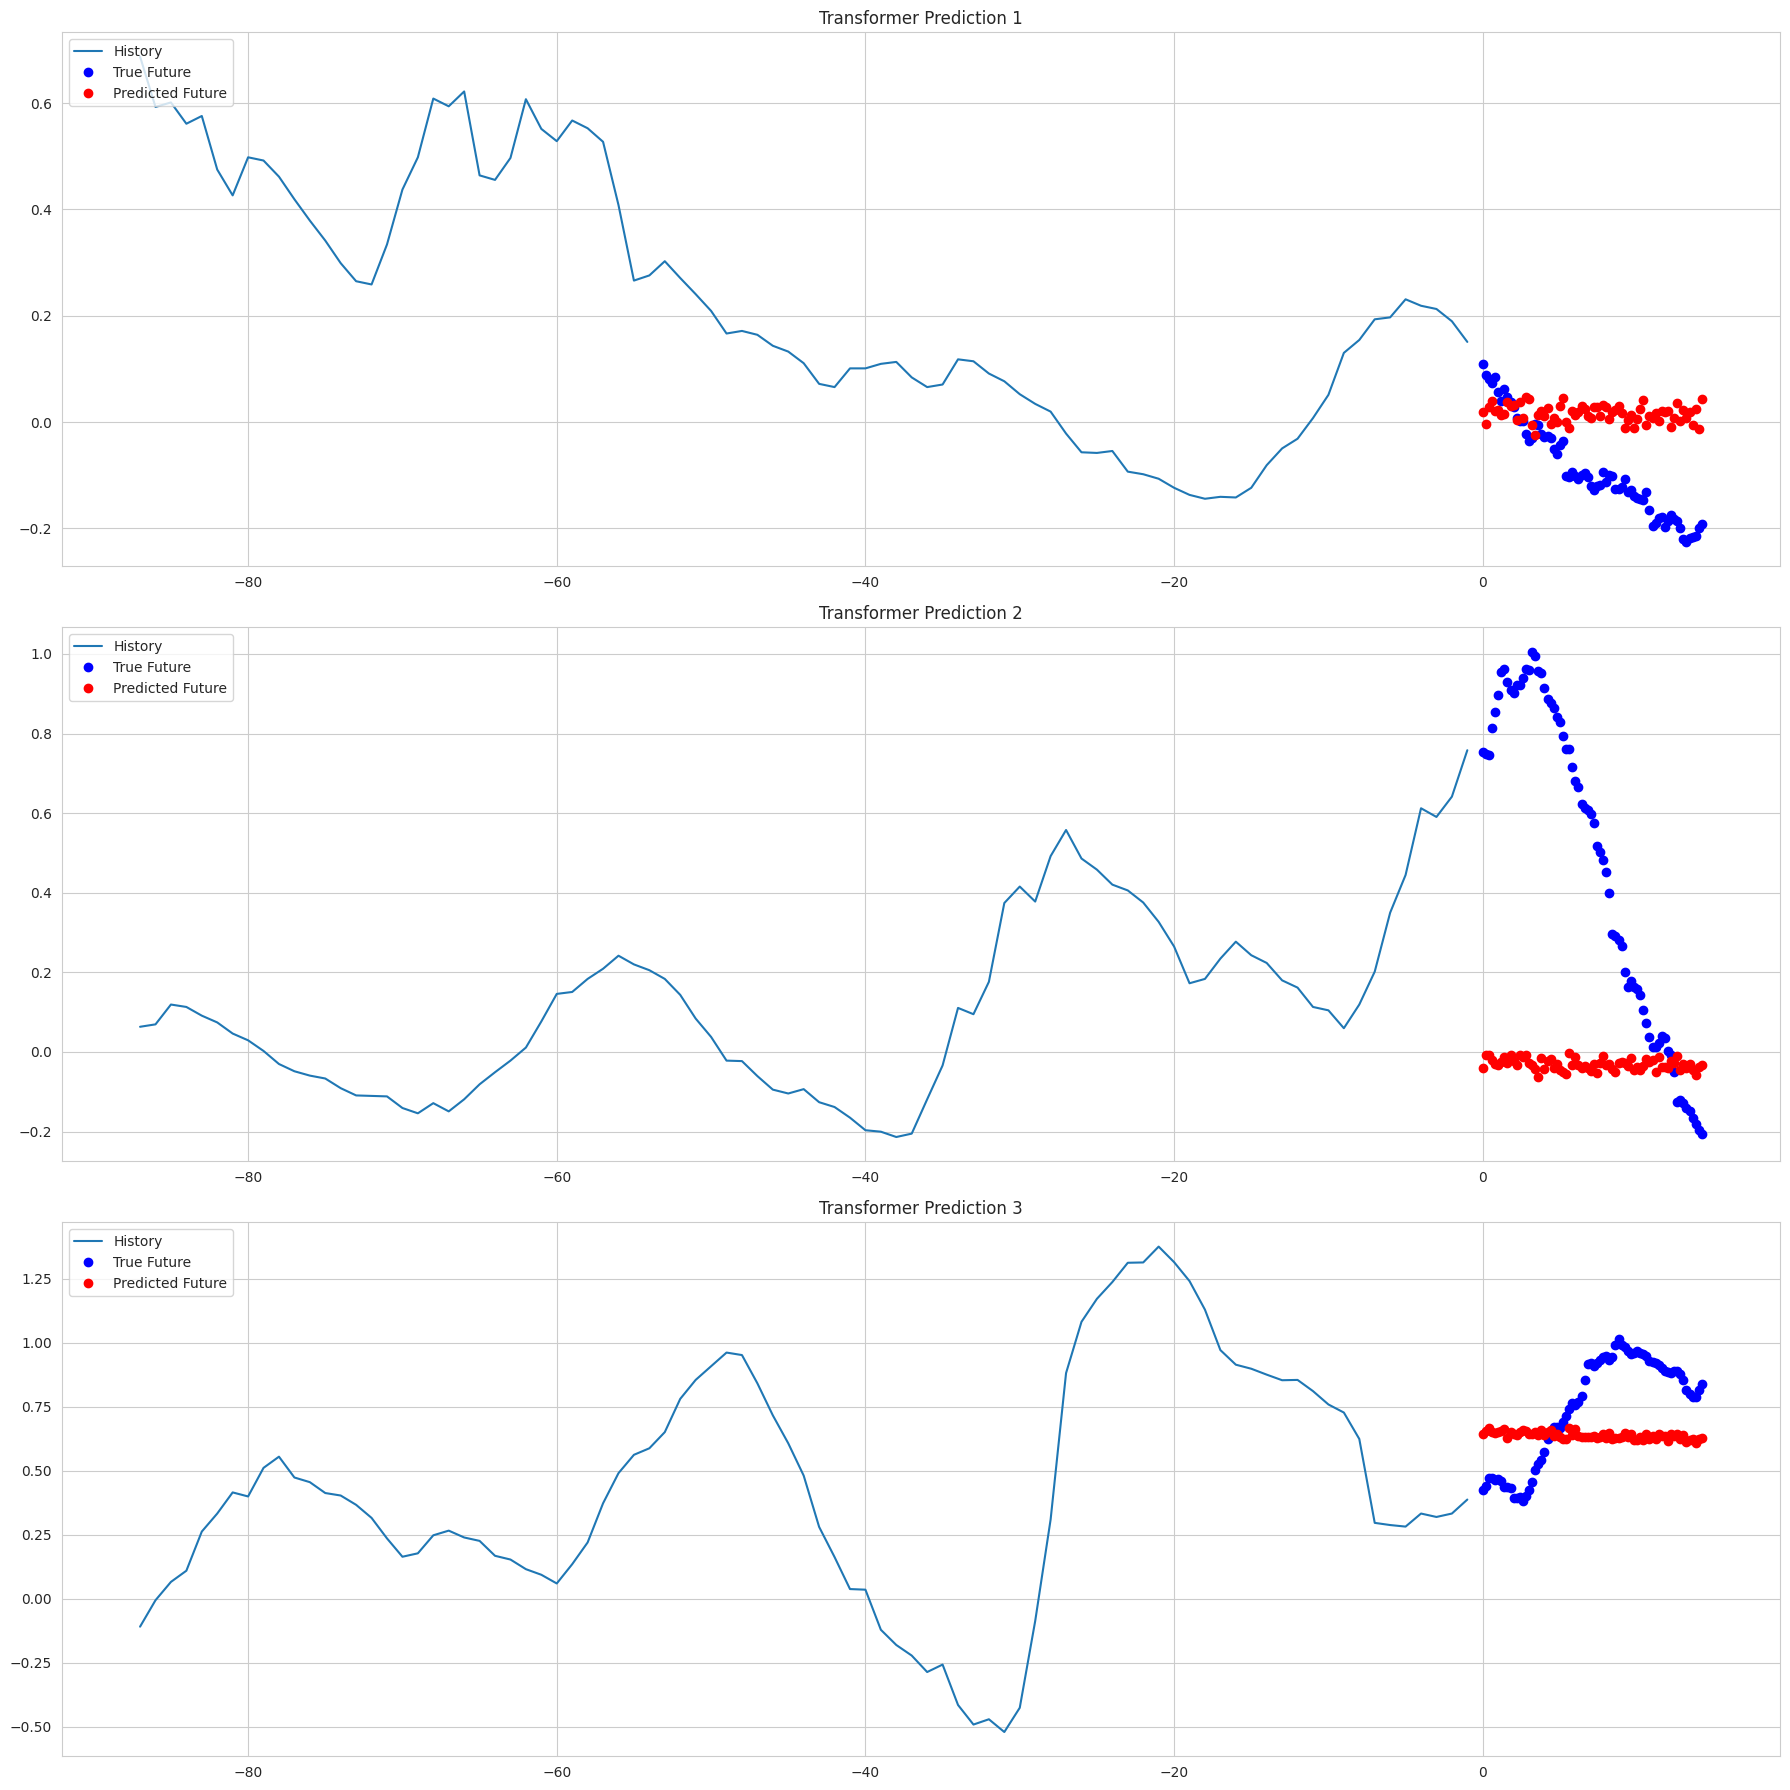

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction, title=""):
    plt.plot(create_time_steps(len(history)), np.array(history[:, 1]), label='History')
    plt.plot(np.arange(len(true_future))/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(len(prediction))/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.title(title)
    plt.legend(loc='upper left')

# Create a figure for all three subplots
plt.figure(figsize=(18, 18))

# Assuming the following loop is part of your code
for i, (x, y) in enumerate(val_data_multi.take(3)):
    prediction = trns_model.predict(x)[0]
    plt.subplot(3, 1, i+1)
    multi_step_plot(x[0], y[0], prediction, title=f'Transformer Prediction {i+1}')

# Adjust layout for better visualization
plt.tight_layout()

# Save the figure as a single file
plt.savefig('432-72-Trans_.png', format='png', dpi=300)

# Show the plot
plt.show()

In [ ]:
del trans_history, transformer_model

# **DEEPAR probabilistic Model**

In [ ]:
pip install tensorflow-probability


In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Define custom loss function for DeepAR
def negative_log_likelihood(y_true, y_pred):
    distribution = tfp.distributions.Normal(loc=y_pred, scale=1)
    return -distribution.log_prob(y_true)

# Define the DeepAR model
deepar_model = Sequential([
    Input(shape=x_train_multi.shape[-2:]),
    LSTM(32, return_sequences=True),
    LSTM(16, activation='relu'),
    Dense(72),
    tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=1))
])

# Compile the DeepAR model with negative log-likelihood loss
deepar_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),
    loss=negative_log_likelihood,
)

# Modify dataset creation to avoid infinite dataset
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE)


# Train the DeepAR model
deepar_history = deepar_model.fit(
    train_data_multi,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_data_multi,
    validation_steps=EVALUATION_INTERVAL,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)


# Evaluate the DeepAR model
deepar_loss = deepar_model.evaluate(val_data_multi)
print(f'DeepAR Model Evaluation - Loss: {deepar_loss:.4f}')


Epoch 1/4
200/200 [==============================] - 29s 123ms/step - loss: 1.9347 - val_loss: 1.5473
Epoch 2/4
200/200 [==============================] - 24s 121ms/step - loss: 1.5109 - val_loss: 1.5215
Epoch 3/4
200/200 [==============================] - 25s 125ms/step - loss: 1.5059 - val_loss: 1.5035
Epoch 4/4
434/434 [==============================] - 6s 14ms/step - loss: 1.4786
DeepAR Model Evaluation - Loss: 1.4786


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate the DeepAR model on the validation data
val_predictions = deepar_model.predict(val_data_multi)

# Calculate MSE and MAE
mse = mean_squared_error(y_val_multi, val_predictions)
mae = mean_absolute_error(y_val_multi, val_predictions)

# Print the metrics
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_multi, val_predictions)

# Print the MAPE
print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}')


434/434 [==============================] - 10s 23ms/step
Mean Squared Error (MSE): 1.1194
Mean Absolute Error (MAE): 0.8439
Mean Absolute Percentage Error (MAPE): 666.0117


8/8 [==============================] - 0s 18ms/step


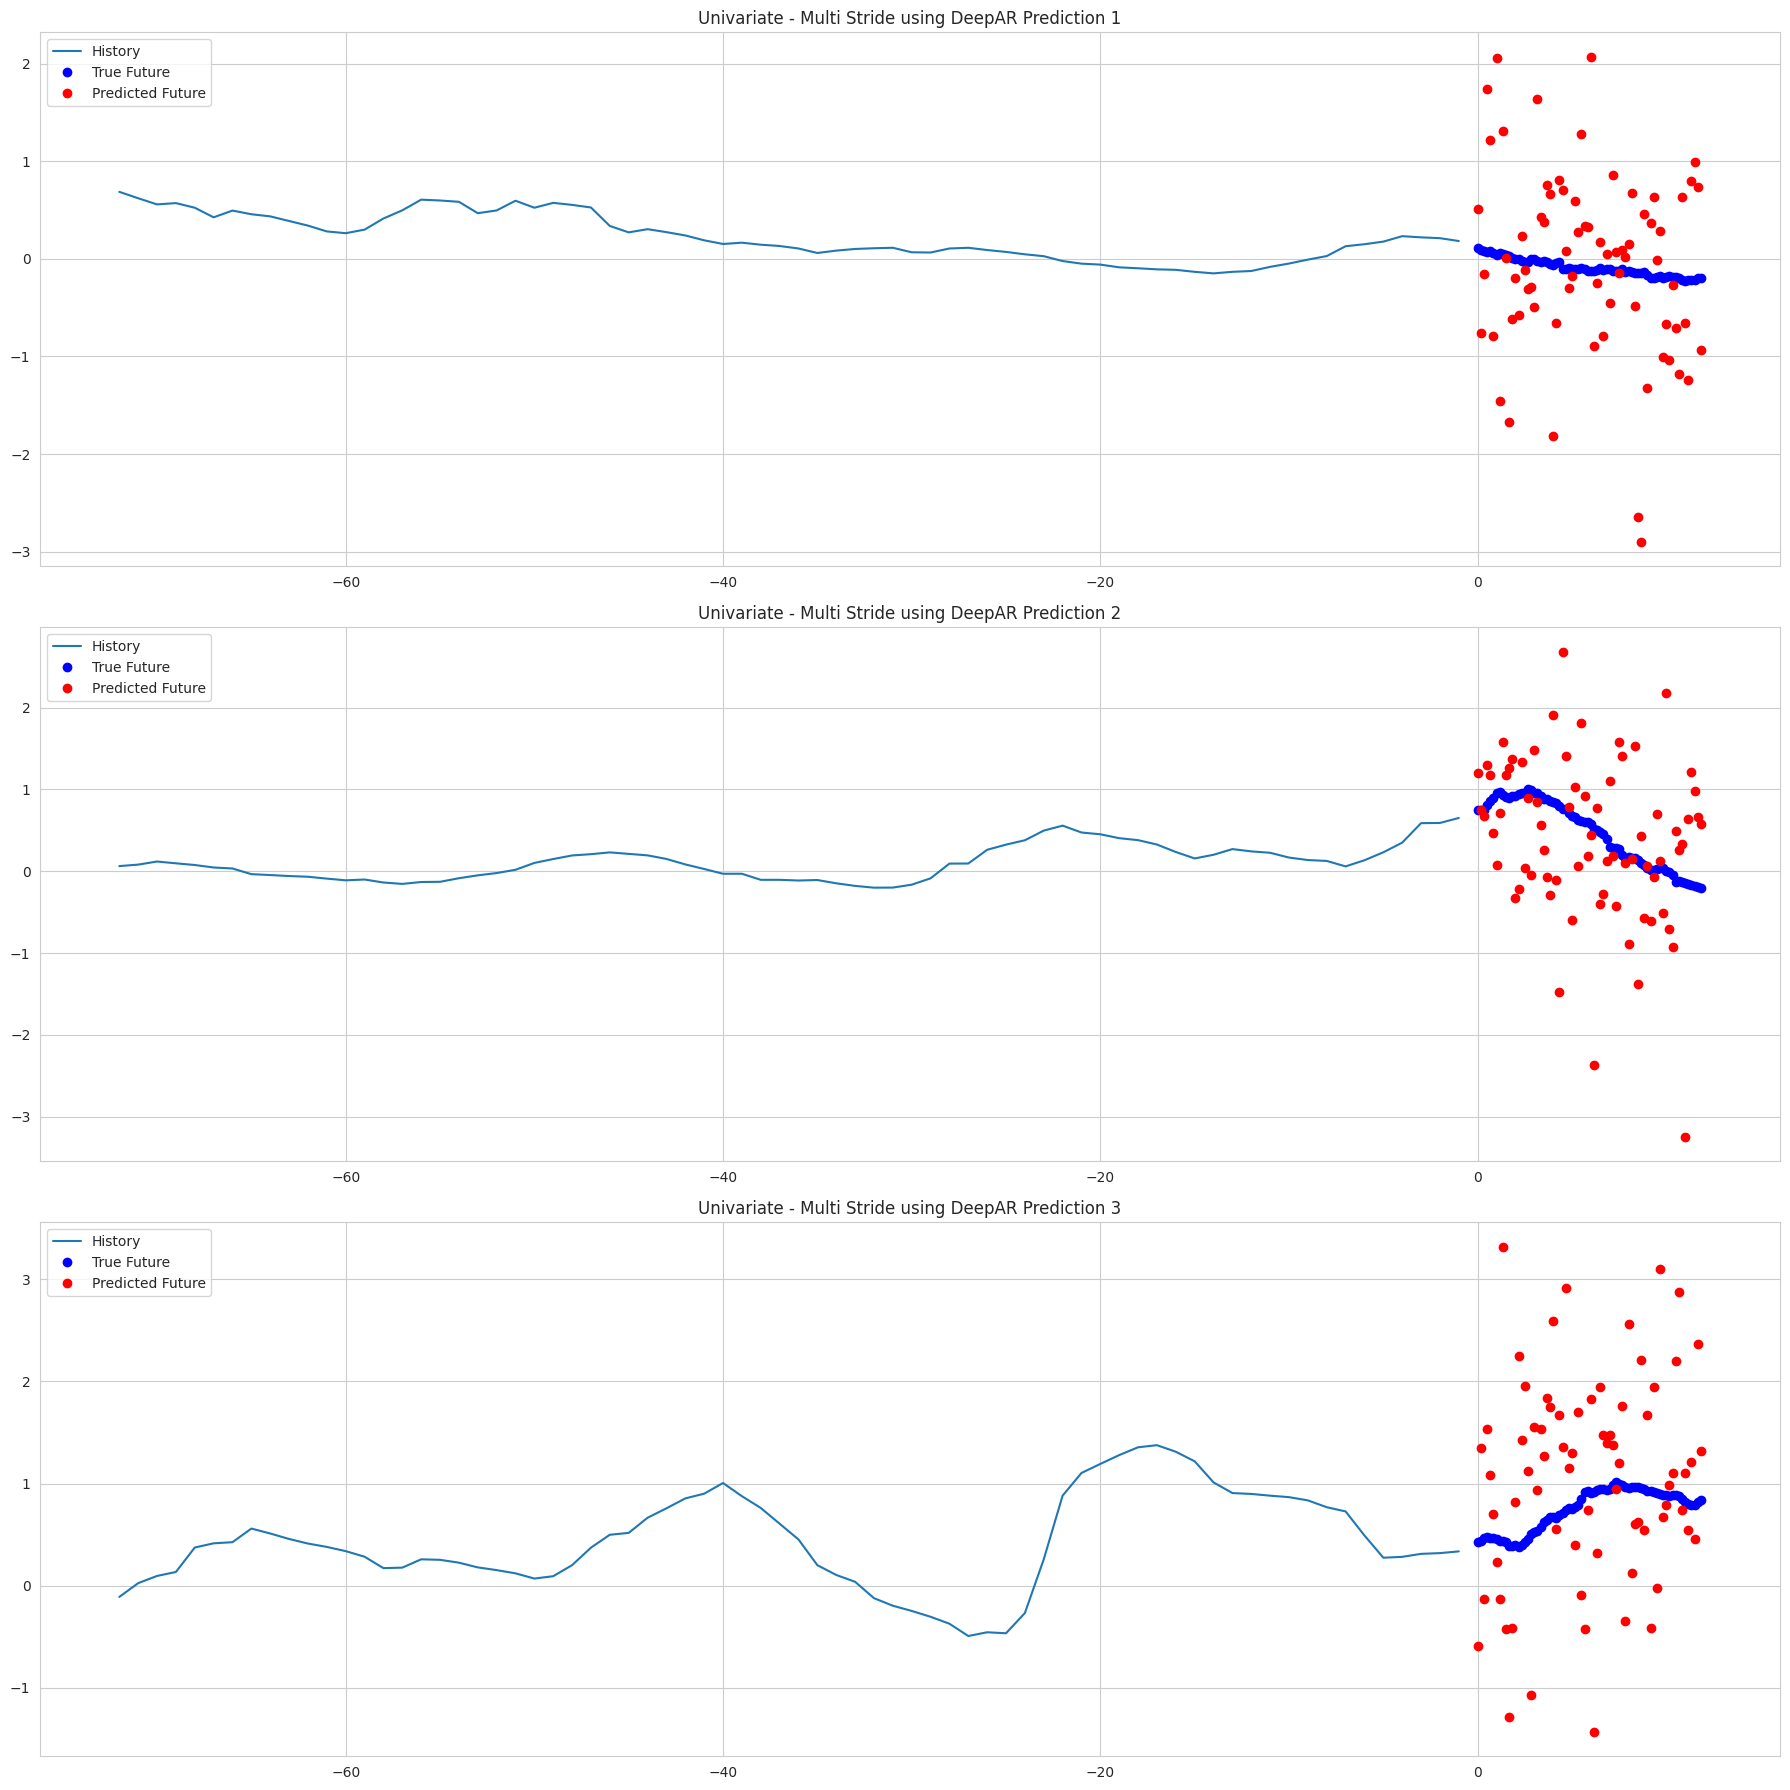

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction, title=""):
    plt.plot(create_time_steps(len(history)), np.array(history[:, 1]), label='History')
    plt.plot(np.arange(len(true_future))/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(len(prediction))/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.title(title)
    plt.legend(loc='upper left')

# Create a figure for all three subplots
plt.figure(figsize=(18, 18))

# Assuming the following loop is part of your code
for i, (x, y) in enumerate(val_data_multi.take(3)):
    prediction = deepar_model.predict(x)[0]
    plt.subplot(3, 1, i+1)
    multi_step_plot(x[0], y[0], prediction, title=f'Univariate - Multi Stride using DeepAR Prediction {i+1}')

# Adjust layout for better visualization
plt.tight_layout()

# Save the figure as a single file
plt.savefig('uvms_deepar_.png', format='png', dpi=300)

# Show the plot
plt.show()

# **Fine Tuned DeepAR model **

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Define the DeepAR model with increased complexity
deepar_model = Sequential([
    Input(shape=x_train_multi.shape[-2:]),
    LSTM(64, return_sequences=True),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(16, activation='relu'),
    Dense(72),
    tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=1))
])

# Compile the DeepAR model with negative log-likelihood loss
deepar_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),
    loss=negative_log_likelihood,
)

# Train the DeepAR model
deepar_history = deepar_model.fit(
    train_data_multi,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_data_multi,
    validation_steps=EVALUATION_INTERVAL,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)
# Evaluate the DeepAR model
deepar_loss = deepar_model.evaluate(val_data_multi)
print(f'DeepAR Model Evaluation - Loss: {deepar_loss:.4f}')

Epoch 1/4
200/200 [==============================] - 53s 245ms/step - loss: 1.7025 - val_loss: 1.5408
Epoch 2/4
200/200 [==============================] - 49s 243ms/step - loss: 1.5038 - val_loss: 1.5273
Epoch 3/4
200/200 [==============================] - 52s 258ms/step - loss: 1.4931 - val_loss: 1.4864
Epoch 4/4
434/434 [==============================] - 15s 35ms/step - loss: 1.4799
DeepAR Model Evaluation - Loss: 1.4799


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate the DeepAR model on the validation data
val_predictions = deepar_model.predict(val_data_multi)

# Calculate MSE and MAE
mse = mean_squared_error(y_val_multi, val_predictions)
mae = mean_absolute_error(y_val_multi, val_predictions)

# Print the metrics
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_multi, val_predictions)

# Print the MAPE
print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}')

434/434 [==============================] - 12s 25ms/step
Mean Squared Error (MSE): 1.1222
Mean Absolute Error (MAE): 0.8450
Mean Absolute Percentage Error (MAPE): 673.4606


8/8 [==============================] - 0s 22ms/step


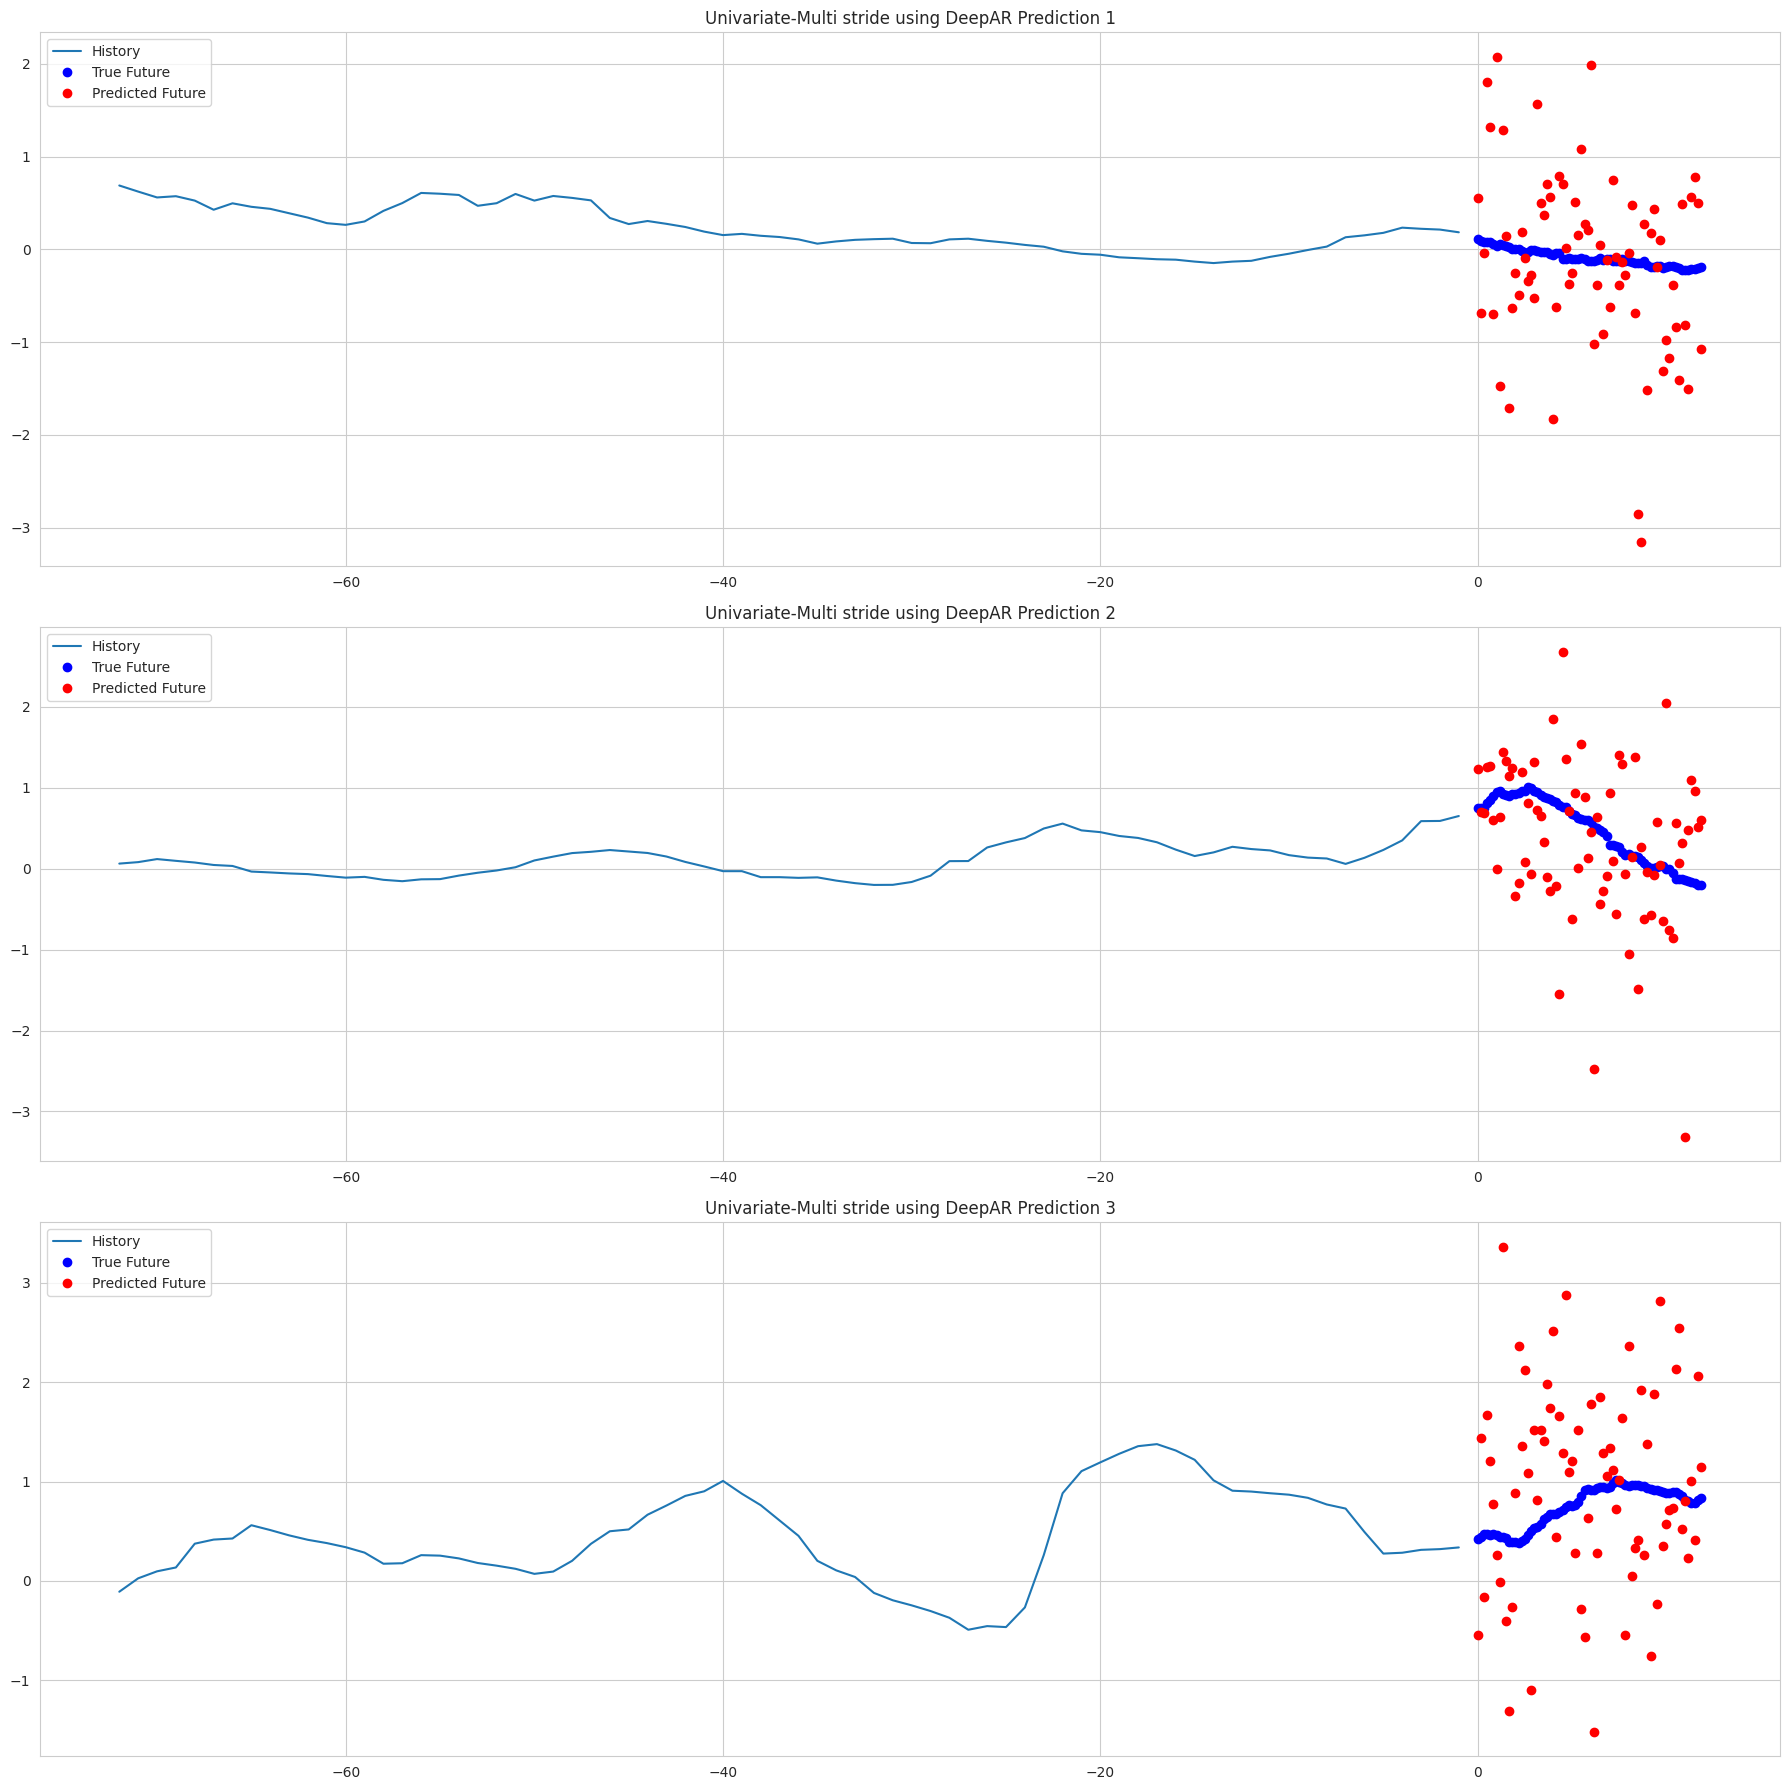

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction, title=""):
    plt.plot(create_time_steps(len(history)), np.array(history[:, 1]), label='History')
    plt.plot(np.arange(len(true_future))/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(len(prediction))/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.title(title)
    plt.legend(loc='upper left')

# Create a figure for all three subplots
plt.figure(figsize=(18, 18))

# Assuming the following loop is part of your code
for i, (x, y) in enumerate(val_data_multi.take(3)):
    prediction = deepar_model.predict(x)[0]
    plt.subplot(3, 1, i+1)
    multi_step_plot(x[0], y[0], prediction, title=f'Univariate-Multi stride using DeepAR Prediction {i+1}')

# Adjust layout for better visualization
plt.tight_layout()

# Save the figure as a single file
plt.savefig('uvms_deeparN_combined.png', format='png', dpi=300)

# Show the plot
plt.show()

In [ ]:
del deepar_model, deepar_history

# **VAE Model**

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Encoder
def build_encoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape)
    h = LSTM(32, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    # Reparameterization Trick using Sampling layer
    z = tf.keras.layers.Lambda(lambda args: tf.random.normal(shape=tf.shape(args[0])) * tf.exp(0.5 * args[1]) + args[0])([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder

# Decoder
def build_decoder(latent_dim, output_shape):
    latent_inputs = Input(shape=(latent_dim,))
    h = RepeatVector(output_shape[0])(latent_inputs)
    h = LSTM(32, activation='relu', return_sequences=True)(h)
    outputs = Dense(output_shape[1], activation='linear')(h)

    decoder = Model(latent_inputs, outputs, name='decoder')
    return decoder

# VAE
def build_vae(encoder, decoder, input_shape, latent_dim):
    x = Input(shape=input_shape)
    z_mean, z_log_var, z = encoder(x)
    x_decoded_mean = decoder(z)

    # Calculate KL Divergence manually
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    kl_loss = tf.keras.backend.mean(kl_loss)

    vae = Model(x, x_decoded_mean, name='vae')
    vae.add_loss(tf.keras.losses.mean_squared_error(x, x_decoded_mean) + kl_loss)
    return vae

# Define input shape and latent dimension
input_shape = x_train_multi.shape[-2:]
latent_dim = 16  # Adjust as needed

# Build encoder, decoder, and VAE
encoder = build_encoder(input_shape, latent_dim)
decoder = build_decoder(latent_dim, input_shape)
vae = build_vae(encoder, decoder, input_shape, latent_dim)

# Compile the VAE model
vae.compile(optimizer='adam')

# Train the VAE
vae.fit(
    x_train_multi,
    x_train_multi,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=(x_val_multi, x_val_multi),
    validation_steps=EVALUATION_INTERVAL,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)


Epoch 1/4
200/200 [==============================] - 50s 227ms/step - loss: 6.2486 - val_loss: 1.0423
Epoch 2/4
200/200 [==============================] - 43s 218ms/step - loss: 1.0393 - val_loss: 0.9982
Epoch 3/4
200/200 [==============================] - 44s 219ms/step - loss: 1.0164 - val_loss: 0.9864
Epoch 4/4
200/200 [==============================] - 43s 214ms/step - loss: 1.0084 - val_loss: 0.9815


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Encoder
def build_encoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape)
    h = LSTM(32, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    # Reparameterization Trick using Sampling layer
    z = tf.keras.layers.Lambda(lambda args: tf.random.normal(shape=tf.shape(args[0])) * tf.exp(0.5 * args[1]) + args[0])([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder

# Decoder
def build_decoder(latent_dim, output_shape):
    latent_inputs = Input(shape=(latent_dim,))
    h = RepeatVector(output_shape[0])(latent_inputs)
    h = LSTM(32, activation='relu', return_sequences=True)(h)
    outputs = Dense(output_shape[1], activation='linear')(h)

    decoder = Model(latent_inputs, outputs, name='decoder')
    return decoder

# VAE
def build_vae(encoder, decoder, input_shape, latent_dim):
    x = Input(shape=input_shape)
    z_mean, z_log_var, z = encoder(x)
    x_decoded_mean = decoder(z)

    # Calculate KL Divergence manually
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    kl_loss = tf.keras.backend.mean(kl_loss)

    vae = Model(x, x_decoded_mean, name='vae')
    vae.add_loss(tf.keras.losses.mean_squared_error(x, x_decoded_mean) + kl_loss)
    return vae

# Define input shape and latent dimension
input_shape = x_train_multi.shape[-2:]
latent_dim = 16  # Adjust as needed

# Build encoder, decoder, and VAE
encoder = build_encoder(input_shape, latent_dim)
decoder = build_decoder(latent_dim, input_shape)
vae = build_vae(encoder, decoder, input_shape, latent_dim)

# Compile the VAE model
vae.compile(optimizer='adam')

# Train the VAE
vae.fit(
    x_train_multi,
    x_train_multi,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=(x_val_multi, x_val_multi),
    validation_steps=EVALUATION_INTERVAL,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)


# **attention based transformer model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Attention, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.models import Model

# Define the Transformer Block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    attn_output = MultiHeadAttention(
        num_heads=num_heads, key_dim=head_size, dropout=dropout
    )(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    return out2

# Define the Transformer model
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0.1):
    inputs = Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformer_block(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
    outputs = Dense(72, activation="linear")(x)  # Adjust the number of units based on your prediction horizon

    model = Model(inputs=inputs, outputs=outputs, name="transformer_model")
    return model

# Set hyperparameters
input_shape = x_train_multi.shape[-2:]
head_size = 32
num_heads = 4
ff_dim = 32
num_transformer_blocks = 4
mlp_units = [32]
dropout = 0.1

# Build and compile the Transformer model
transformer_model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout)
transformer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')  # Adjust the optimizer and loss as needed

# Train the Transformer model
transformer_history = transformer_model.fit(
    train_data_multi,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_data_multi,
    validation_steps=EVALUATION_INTERVAL,
    callbacks=[early_stopping]
)


Epoch 1/4
200/200 [==============================] - 27s 68ms/step - loss: 0.5030 - val_loss: 0.3341
Epoch 2/4
200/200 [==============================] - 13s 64ms/step - loss: 0.2334 - val_loss: 0.3241
Epoch 3/4
200/200 [==============================] - 13s 63ms/step - loss: 0.2853 - val_loss: 0.3445
Epoch 4/4
200/200 [==============================] - 13s 65ms/step - loss: 0.2810 - val_loss: 0.3229


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate the DeepAR model on the validation data
val_predictions = transformer_model.predict(val_data_multi)

# Calculate MSE and MAE
mse = mean_squared_error(y_val_multi, val_predictions)
mae = mean_absolute_error(y_val_multi, val_predictions)

# Print the metrics
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_multi, val_predictions)

# Print the MAPE
print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}')

434/434 [==============================] - 8s 16ms/step
Mean Squared Error (MSE): 0.3123
Mean Absolute Error (MAE): 0.4485
Mean Absolute Percentage Error (MAPE): 355.5551


8/8 [==============================] - 0s 33ms/step


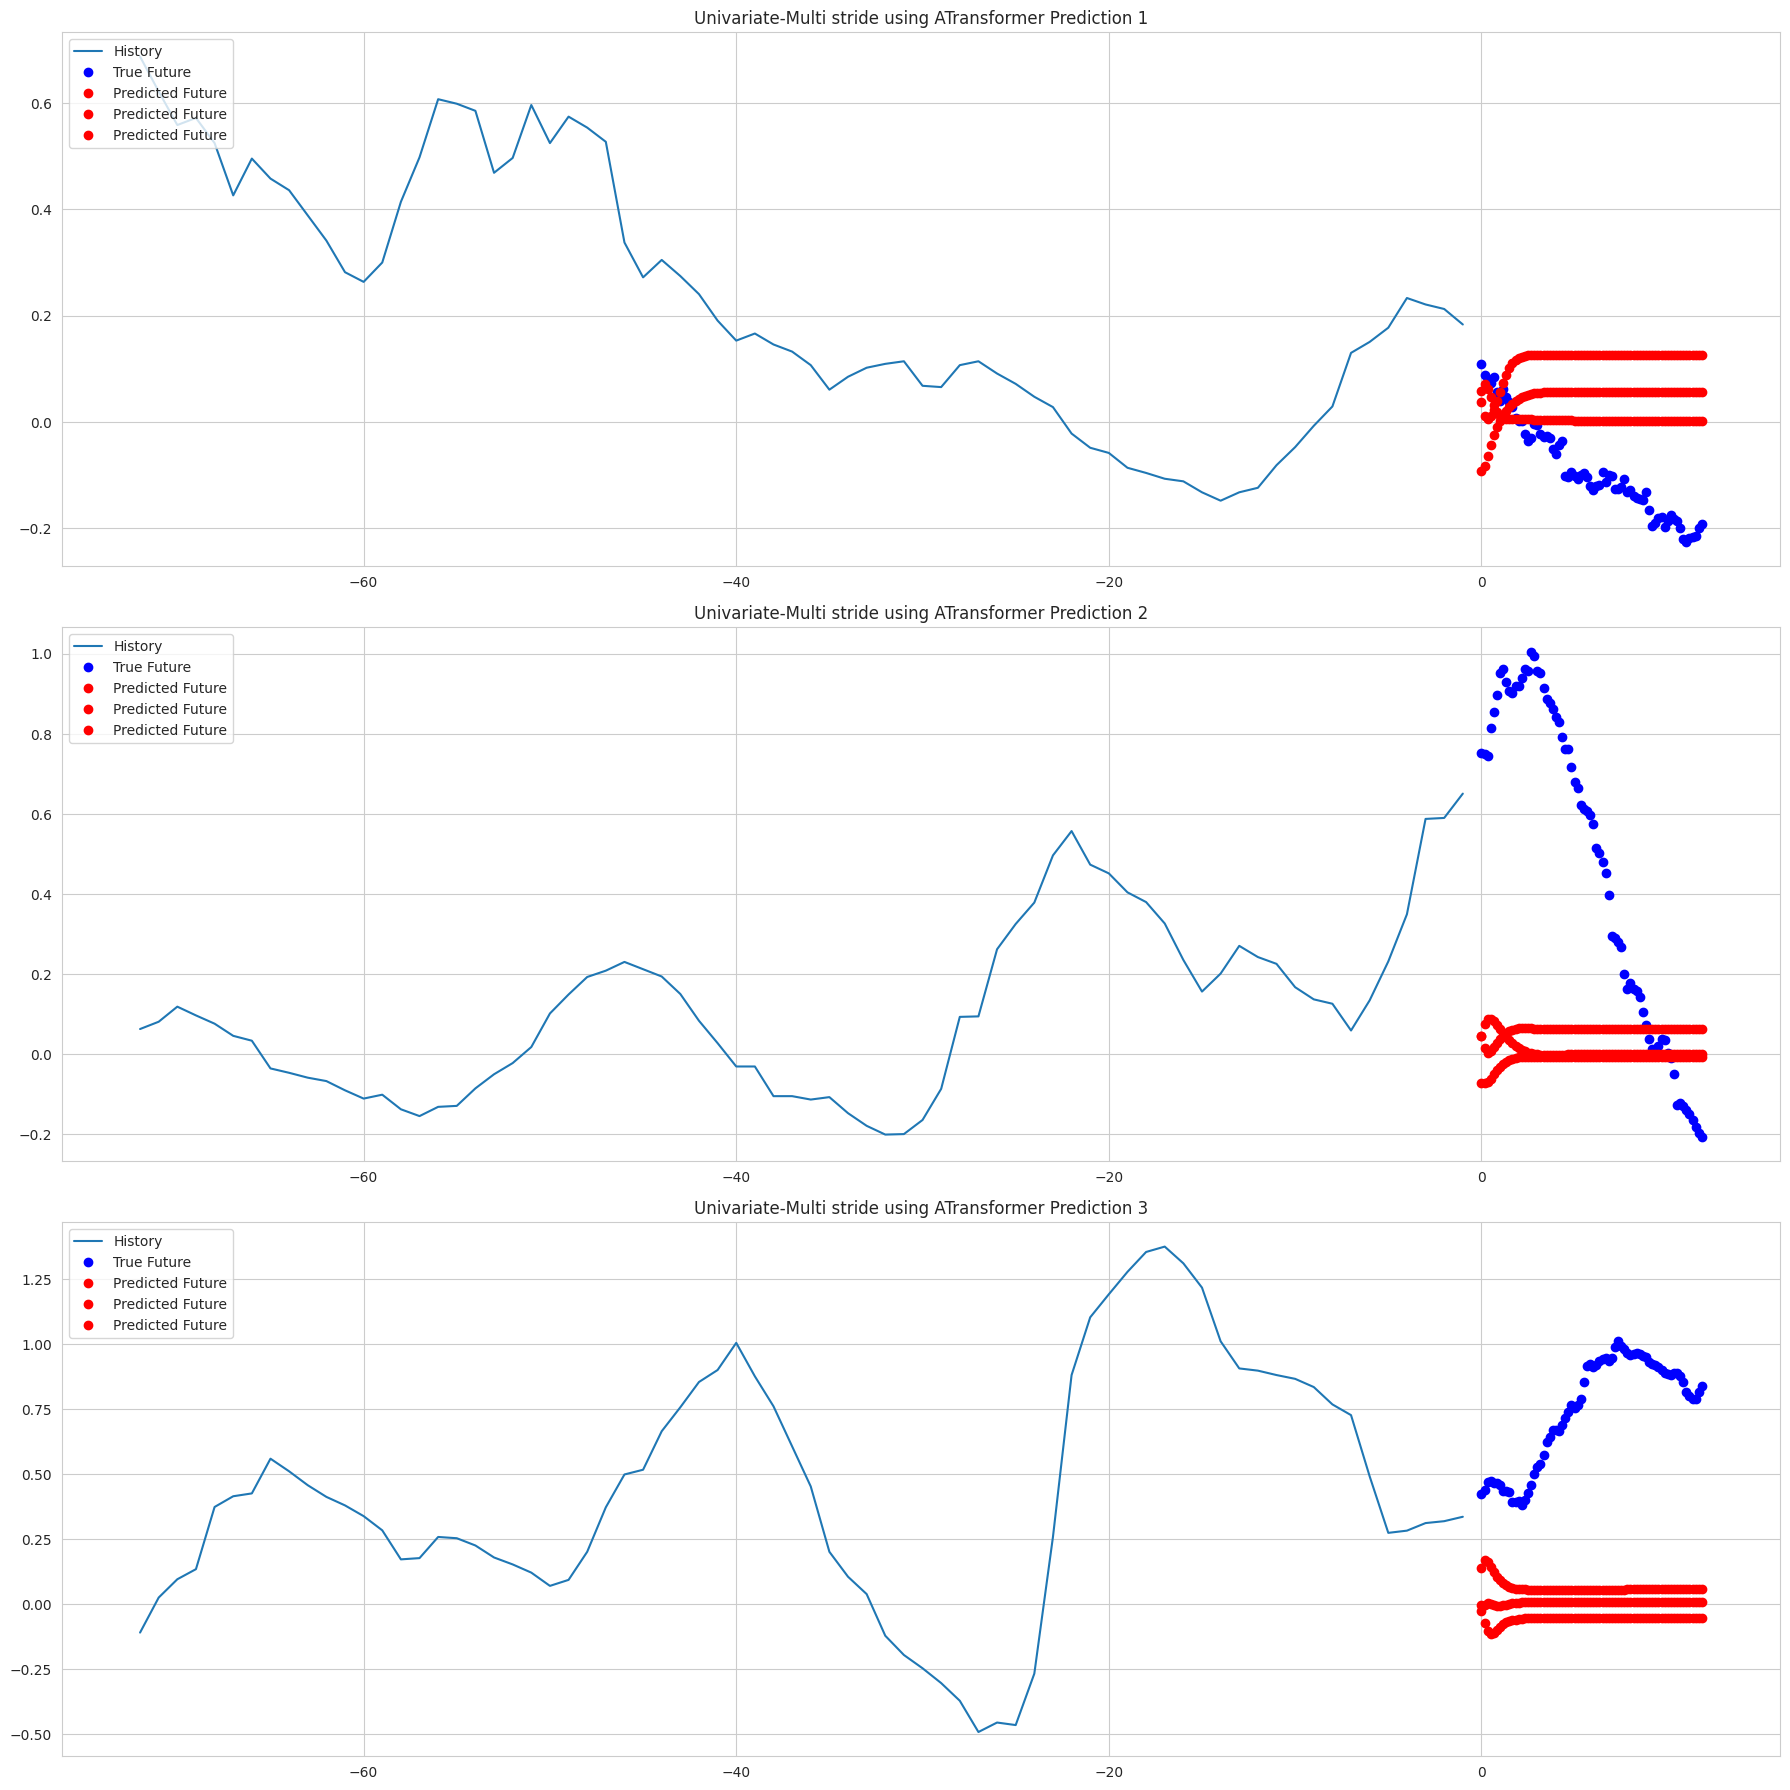

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction, title=""):
    plt.plot(create_time_steps(len(history)), np.array(history[:, 1]), label='History')
    plt.plot(np.arange(len(true_future))/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(len(prediction))/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.title(title)
    plt.legend(loc='upper left')

# Create a figure for all three subplots
plt.figure(figsize=(18, 18))

# Assuming the following loop is part of your code
for i, (x, y) in enumerate(val_data_multi.take(3)):
    prediction = vae.predict(x)[0]
    plt.subplot(3, 1, i+1)
    multi_step_plot(x[0], y[0], prediction, title=f'Univariate-Multi stride using ATransformer Prediction {i+1}')

# Adjust layout for better visualization
plt.tight_layout()

# Save the figure as a single file
plt.savefig('uvms_ATransformer_combined.png', format='png', dpi=300)

# Show the plot
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Reshape, LayerNormalization, MultiHeadAttention, Dropout, Lambda, concatenate
from tensorflow.keras.models import Model
from tcn import TCN
import tensorflow_probability as tfp

# Define custom loss function for VAE
def negative_log_likelihood(y_true, y_pred):
    distribution = tfp.distributions.Normal(loc=y_pred, scale=1)
    return -distribution.log_prob(y_true)

# Define the TCN model
def build_tcn_model(input_shape):
    tcn_model = Sequential([
        TCN(nb_filters=32, kernel_size=3, dropout_rate=0.2),
        Flatten(),
        Dense(16, activation='relu')
    ])
    inputs = Input(shape=input_shape)
    outputs = tcn_model(inputs)
    return Model(inputs=inputs, outputs=outputs)

# Define the LSTM model
def build_lstm_model(input_shape):
    lstm_model = Sequential([
        LSTM(32, return_sequences=True),
        LSTM(16, activation='relu')
    ])
    inputs = Input(shape=input_shape)
    outputs = lstm_model(inputs)
    return Model(inputs=inputs, outputs=outputs)

# Define the VAE model
def build_vae_model(input_shape, latent_dim=8):
    encoder_inputs = Input(shape=input_shape)
    x = Flatten()(encoder_inputs)
    x = Dense(32, activation='relu')(x)

    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # Reparameterization trick
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

    decoder_inputs = Input(shape=(latent_dim,))
    x = Dense(32, activation='relu')(decoder_inputs)
    x = Dense(tf.reduce_prod(input_shape), activation='sigmoid')(x)
    decoder_outputs = Reshape(input_shape)(x)

    decoder = Model(decoder_inputs, decoder_outputs, name='decoder')

    vae_outputs = decoder(encoder(encoder_inputs)[2])
    vae_model = Model(encoder_inputs, vae_outputs, name='vae')

    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    vae_model.add_loss(tf.reduce_mean(kl_loss) * 0.01)  # Add KL divergence term

    return vae_model

# Define the transformer block
def build_transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = inputs

    for _ in range(num_heads):
        x = MultiHeadAttention(
            head_size=head_size, num_heads=num_heads, dropout=dropout
        )(x, x, x)
        x = Dropout(dropout)(x)
        x = LayerNormalization(epsilon=1e-6)(x + inputs)

    x = FeedForward(ff_dim=ff_dim)(x)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)

    return x

# Define the combined model
def build_combined_model(input_shape, vae_latent_dim=8, lstm_units=32, tcn_units=32, transformer_params=None):
    inputs = Input(shape=input_shape)

    # VAE
    vae_model = build_vae_model(input_shape, latent_dim=vae_latent_dim)
    vae_outputs = vae_model(inputs)

    # LSTM
    lstm_outputs = LSTM(lstm_units, return_sequences=True)(inputs)

    # TCN
    tcn_outputs = TCN(return_sequences=True, nb_filters=tcn_units, kernel_size=3, dilations=[1, 2, 4, 8, 16])(inputs)

    # Transformer
    if transformer_params:
        transformer_outputs = build_transformer_block(inputs, **transformer_params)
    else:
        transformer_outputs = LSTM(lstm_units, return_sequences=True)(inputs)  # Provide a default behavior when transformer_params is None

    # Combine outputs
    combined_outputs = concatenate([vae_outputs, lstm_outputs, tcn_outputs, transformer_outputs], axis=-1)

    # Additional layers and output
    x = Dense(64, activation='relu')(combined_outputs)
    x = Dense(32, activation='relu')(x)
    final_output = Dense(72, activation='linear')(x)

    model = Model(inputs=inputs, outputs=final_output, name='combined_model')

    return model

# Set hyperparameters
input_shape = x_train_multi.shape[-2:]

# Build the combined model
combined_model = build_combined_model(input_shape)

# Define custom metrics
custom_metrics = [
    tf.keras.metrics.MeanSquaredError(name='mse'),
    tf.keras.metrics.MeanAbsoluteError(name='mae'),
    # Define a custom MAPE metric
    tf.keras.metrics.MeanAbsolutePercentageError(name='mape')
]
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Compile the model with custom metrics
combined_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),
    loss='mse',
    metrics=custom_metrics
)

# Train the combined model
combined_history = combined_model.fit(
    train_data_multi,  # Use the dataset directly
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_data_multi,  # Use the dataset directly
    validation_steps=EVALUATION_INTERVAL,
    callbacks=[early_stopping]
)


Epoch 1/4


InvalidArgumentError: ignored